# <p style="background-color:#19415E;font-family:newtimeroman;color:#EFEFEE;font-size:150%;text-align:center;border-radius:10px 10px;">Ticket Volume Forecast</p>


_Cozentus PVT Limited (January 2024)_

Goal:

- Explore the data (ECDF, handle missing values etc).
- Analysis per store type and correlational analysis of stores activity.
- Perform extensive Time Series Analysis (seasonal decomposition, trends, autocorrelation).
- Predict next 6 weeks of sales using Prophet (Facebook methodology).


In this notebook, we will walk through the process of time series forecasting of Call Volume using the Prophet model. Time series forecasting is a critical task in various domains, from finance to supply chain management. We will perform the following steps:

1. Importing Library:

  To get started, we import the necessary Python libraries required for time series forecasting with the Prophet model. These libraries will enable us to manipulate and visualize time series data efficiently.

2. Loading and Splitting Required Clean Data:

  In this step, we load our time series data. We will also split the data into training and testing sets, ensuring that we have a portion of the data reserved for evaluating the model's performance.

3. Training Models on Whole Data:

  We begin by training our initial Prophet model on the entire dataset. This model will provide an overall forecast based on historical data.

4. Training New Categories with New Data Only:

  As new data becomes available, we train additional categories within our Prophet model. This allows us to continuously update our forecast to account for changing trends and patterns.

5. Data Visualization:

  Data visualization is a crucial aspect of time series forecasting. In this section, we create visualizations to better understand our time series data, historical trends, and the model's forecasts.

6. Testing Models Created on Whole Data:

  After training our initial Prophet model on the complete dataset, we assess its performance by testing it on the testing dataset. This evaluation helps us understand how well the model generalizes to unseen data.

7. Testing Models Trained on New Data:

  Similarly, we evaluate the performance of models trained on new data. This step is essential in assessing how well the model adapts to changing patterns and whether it continues to provide accurate forecasts as new data is incorporated.

By following the flow of this notebook, we aim to achieve accurate time series forecasts and maintain the model's effectiveness as new data arrives. Time series forecasting is vital for making informed decisions and predictions in various applications.

## 1. Importing Libraries

In [1]:
# Import necessary libraries
import os  # Operating System module for interacting with the operating system
import shutil # File operation module
import zipfile #Zip module for archieving
import subprocess  # Subprocess module for spawning new processes
import numpy as np  # NumPy for numerical operations
import plotly  # Plotly for interactive and online plotting
import pandas as pd  # Pandas for data manipulation and analysis
import seaborn as sns  # Seaborn for statistical data visualization
from sklearn.metrics import r2_score  # R-squared score metric
from prophet import Prophet  # Prophet library for time series forecasting
import matplotlib.pyplot as plt  # Matplotlib for 2D plotting
from sklearn.metrics import mean_absolute_percentage_error  # Mean Absolute Percentage Error (MAPE) metric
from prophet.serialize import model_to_json, model_from_json  # Serialization functions for Prophet model

## 2. Importing Data

In [2]:
# Define the full file path for the Excel file
full_file_path = 'uploaded_excel_file_2024-05-13.xlsx'

# Read the Excel file into a Pandas DataFrame
dataset_original_ticket = pd.read_excel(full_file_path)


In [3]:
# Create a copy of the original dataset
dataset_latest_ticket = dataset_original_ticket.copy()

In [5]:
dataset_latest_ticket.head()

Line           Call Date                      Object ID  \
0  Second line ticket 2023-03-01 13:57:00      12 - DFDS Stevedoring A/S   
1  Second line ticket 2023-03-02 13:51:00  23456789 - DFDS Logistics A/S   
2  Second line ticket 2023-03-31 14:10:01                            NaN   
3  Second line ticket 2023-03-31 15:26:16                            NaN   
4  Second line ticket 2023-03-31 16:59:58                            NaN   

  Phase_LE (Reporting) Progress Ticket Number   Caller name   Site (Caller)  \
0                 Live   Closed  D365-2303004        tester  TOPdesk system   
1                  NaN   Closed  D365-2303009  Adelina Zych            DFDS   
2                  NaN   Closed  D365-2303029     Aleyna Ak            DFDS   
3                  NaN   Closed  D365-2303034  Adelina Zych            DFDS   
4                  NaN   Closed  D365-2303036      Eda Önal            DFDS   

  Ticket Type  Status  ... Supplier Service  Telephone number (Caller)  \
0     Request  Closed  ...              NaN                        NaN   
1    Incident  Closed  ...              NaN                        NaN   
2    Incident  Closed  ...              NaN                        NaN   
3     Request  Closed  ...              NaN                        NaN   
4     Request  Closed  ...              NaN                        NaN   

   This ticket has a conversation in Worcade. Time spent for First line  \
0                                       False                  00:00:00   
1                                       False                  00:00:00   
2                                       False                  00:00:00   
3                                       False                  00:00:00   
4                                       False                  00:00:00   

  Time spent for Second Line Total Costs Total costs  \
0                   00:00:00           0           0   
1                   00:00:00           0           0   
2                   00:00:00           0           0   
3                   00:00:00           0           0   
4                   00:00:00           0           0   

  Training topic brief description (Training need)                 Urgency  \
0                                              NaN  Partially able to work   
1                                              NaN            Able to work   
2                                              NaN            Able to work   
3                                              NaN                     NaN   
4                                              NaN                     NaN   

   Visible to  
0       False  
1       False  
2       False  
3       False  
4       False  

[5 rows x 80 columns]

In [6]:
dataset_latest_ticket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16943 entries, 0 to 16942
Data columns (total 80 columns):
 #   Column                                             Non-Null Count  Dtype         
---  ------                                             --------------  -----         
 0   Line                                               16943 non-null  object        
 1   Call Date                                          16943 non-null  datetime64[ns]
 2   Object ID                                          10620 non-null  object        
 3   Phase_LE (Reporting)                               10588 non-null  object        
 4   Progress                                           16943 non-null  object        
 5   Ticket Number                                      16943 non-null  object        
 6   Caller name                                        16943 non-null  object        
 7   Site (Caller)                                      16943 non-null  object        
 8   Ticket Type     

## 3. Function Defination

In [4]:
def date_filler(df,date_col):
  date_range = pd.date_range(start=df[date_col].min(), end=df[date_col].max())

  # Create a new DataFrame with all dates and fill missing values with 0
  new_df = df.set_index(date_col).reindex(date_range).fillna(0)

  # Reset the index to obtain the final DataFrame
  new_df = new_df.reset_index()
  new_df.columns=[date_col]+list(new_df.columns[1:])
  return new_df

In [5]:
def save_model(model_name,file_name):
  with open(file_name, 'w') as fout:
    fout.write(model_to_json(model_name))  # Save model

In [6]:
def process_json_files(target_dir="newjson", zip_file_name="newjson.zip"):
    """
    Removes any existing directory and ZIP file, creates a new directory,
    copies JSON files into it, and creates a ZIP archive of the directory.

    Args:
        target_dir (str, optional): Name of the directory to create. Defaults to "newjson".
        zip_file_name (str, optional): Name of the ZIP file to create. Defaults to "newjson.zip".
    """

    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)  # Remove existing directory recursively
    if os.path.exists(zip_file_name):
        os.remove(zip_file_name)  # Remove existing ZIP file

    os.mkdir(target_dir)  # Create the target directory

    for filename in os.listdir():
        if filename.endswith(".json"):
            shutil.copy(filename, target_dir)  # Copy JSON files

    print("Copied!")

    with zipfile.ZipFile(zip_file_name, "w") as zipf:
        for root, _, files in os.walk(target_dir):
            for file in files:
                zipf.write(os.path.join(root, file))  # Add files to ZIP archive

    print("Archived!")

In [7]:
def load_model(model_path):
    # Open the specified file ('model_path') in read mode
    with open(model_path, "r") as fin:
        # Read the contents of the file into a string ('model_json')
        model_json = fin.read()

    # Deserialize the model from the JSON representation
    model = model_from_json(model_json)

    # Return the deserialized model
    return model

## 4. Preprocessing Data

### 4.1 Common Preprocessing

In [9]:
dataset_latest_ticket['Call Date']

0        2023-03-01
1        2023-03-02
2        2023-03-31
3        2023-03-31
4        2023-03-31
            ...    
16938    2024-05-13
16939    2024-05-13
16940    2024-05-13
16941    2024-05-13
16942    2024-05-13
Name: Call Date, Length: 16943, dtype: object

In [8]:
# Extract the date part of the 'Call Date' column and overwrite it
dataset_latest_ticket['Call Date'] = dataset_latest_ticket['Call Date'].dt.date

### 4.2 Base Model

In [9]:

# Group the data by 'Call Date', count the occurrences of each date, fill missing values with 0,
# and reset the index to create a new DataFrame ('dataset_pivot_daily_count')
dataset_pivot_daily_count = dataset_latest_ticket.groupby('Call Date')['Ticket Number'].count().fillna(0).reset_index()

# Note: This line performs a groupby operation on the 'Call Date' column, counting the number of occurrences (tickets) for each date.
# The result is stored in a new DataFrame ('dataset_pivot_daily_count') with 'Call Date' as the index and a count of tickets for each date.
# Any missing values are filled with 0, and the index is reset to make 'Call Date' a regular column in the resulting DataFrame.

In [10]:
# Assuming there is a function named 'date_filler' that fills in missing dates in a time series
# Call the 'date_filler' function to fill in missing dates in the 'Call Date' column of 'dataset_pivot_daily_count'
dataset_pivot_daily_count = date_filler(dataset_pivot_daily_count, 'Call Date')

# Note: This line calls a function 'date_filler' to fill in missing dates in the time series.
# The function is assumed to take a DataFrame and the name of the date column ('Call Date') as arguments and return a modified DataFrame.


In [11]:
# Rename the 'Ticket Number' column to 'all' in the 'dataset_pivot_daily_count' DataFrame
dataset_pivot_daily_count.rename(columns={'Ticket Number': 'all'}, inplace=True)

# Note: This line uses the 'rename' method to change the name of the 'Ticket Number' column to 'all'.
# The 'inplace=True' parameter modifies the DataFrame in place, without the need for assignment.


In [12]:
# Set the ratio for training data (80% in this case)
train_ratio = 0.8

# Define whether the shape accessor refers to rows (0) or columns (1)
row_counts_or_column_counts_accessor = 0  # 0 for rows, 1 for columns

# Create a copy of the training dataset based on the specified ratio
dataset_training_base = dataset_pivot_daily_count.iloc[:int(dataset_pivot_daily_count.shape[row_counts_or_column_counts_accessor] * train_ratio), :].copy()

# Create a copy of the testing dataset based on the remaining data
dataset_testing_base = dataset_pivot_daily_count.iloc[int(dataset_pivot_daily_count.shape[row_counts_or_column_counts_accessor] * train_ratio):, :].copy()

# Note: This code snippet divides the dataset into training and testing sets based on the specified ratio.
# The 'iloc' method is used for integer-location based indexing to select the rows for training and testing.
# The parameter 'row_counts_or_column_counts_accessor' determines whether to consider rows or columns for shape calculation.


In [13]:
# Reset the index of the training dataset in place
dataset_training_base.reset_index(inplace=True)

# Reset the index of the testing dataset in place
dataset_testing_base.reset_index(inplace=True)

# Note: This code snippet uses the 'reset_index' method to reset the index of the training and testing datasets.
# The 'inplace=True' parameter modifies the DataFrames in place, without the need for assignment.
# Resetting the index is useful when you want to reorganize the DataFrame and make the index continuous.


### 4.3 Category Wise Models

In [14]:
# Create a pivot table with category-wise daily ticket counts
dataset_pivot_category_wise_daily_count = dataset_latest_ticket.pivot_table(
    columns=['Category'],  # Pivot by 'Category'
    index='Call Date',  # Rows represent 'Call Date'
    values='Ticket Number',  # Values to aggregate (count of tickets)
    aggfunc='count'  # Aggregation function is count to get the number of tickets for each category on each date
).fillna(0)  # Fill missing values with 0

# Note: This line uses the 'pivot_table' method to create a new DataFrame with 'Category' as columns, 'Call Date' as rows,
# and the count of 'Ticket Number' as values. Missing values (dates without tickets for a category) are filled with 0.


In [15]:
# Reset the index of the category-wise daily count pivot table in place
dataset_pivot_category_wise_daily_count.reset_index(inplace=True)

# Assuming there is a function named 'date_filler' that fills in missing dates in a time series
# Call the 'date_filler' function to fill in missing dates in the 'Call Date' column of 'dataset_pivot_category_wise_daily_count'
dataset_pivot_category_wise_daily_count = date_filler(dataset_pivot_category_wise_daily_count, 'Call Date')

# Note: These lines first reset the index of the category-wise daily count pivot table.
# Then, assuming there is a function named 'date_filler', it is called to fill in missing dates in the time series.
# The 'date_filler' function is assumed to take a DataFrame and the name of the date column ('Call Date') as arguments
# and return a modified DataFrame with filled missing dates.


In [16]:
# Set the ratio for training data (80% in this case)
train_ratio = 0.8

# Define whether the shape accessor refers to rows (0) or columns (1)
row_counts_or_column_counts_accessor = 0  # 0 for rows, 1 for columns

# Create a copy of the training dataset based on the specified ratio for category-wise daily counts
dataset_training_category_wise = dataset_pivot_category_wise_daily_count.iloc[:int(
    dataset_pivot_category_wise_daily_count.shape[row_counts_or_column_counts_accessor] * train_ratio), :].copy()

# Create a copy of the testing dataset based on the remaining data for category-wise daily counts
dataset_testing_category_wise = dataset_pivot_category_wise_daily_count.iloc[int(
    dataset_pivot_category_wise_daily_count.shape[row_counts_or_column_counts_accessor] * train_ratio):, :].copy()

# Note: This code snippet divides the category-wise daily count pivot table into training and testing sets based on the specified ratio.
# The 'iloc' method is used for integer-location based indexing to select the rows for training and testing.
# The parameter 'row_counts_or_column_counts_accessor' determines whether to consider rows or columns for shape calculation.


### 4.4 Priority Wise Models

In [17]:
# Create a pivot table with priority-wise daily ticket counts
dataset_pivot_priority_wise_daily_count = dataset_latest_ticket.pivot_table(
    columns=['Priority'],  # Pivot by 'Priority'
    index='Call Date',  # Rows represent 'Call Date'
    values='Ticket Number',  # Values to aggregate (count of tickets)
    aggfunc='count'  # Aggregation function is count to get the number of tickets for each priority on each date
).fillna(0)  # Fill missing values with 0

# Note: This line uses the 'pivot_table' method to create a new DataFrame with 'Priority' as columns, 'Call Date' as rows,
# and the count of 'Ticket Number' as values. Missing values (dates without tickets for a priority) are filled with 0.


In [18]:
# Rename the columns of the priority-wise daily count pivot table
dataset_pivot_priority_wise_daily_count.columns = ['P1', 'P2', 'P3', 'P4', 'P6']

# Note: This line uses the 'columns' attribute to rename the columns of the priority-wise daily count pivot table.
# The columns are renamed to 'P1', 'P2', 'P3', 'P4', and 'P6', presumably representing different priority levels.


In [19]:
# Reset the index of the priority-wise daily count pivot table in place
dataset_pivot_priority_wise_daily_count.reset_index(inplace=True)

# Assuming there is a function named 'date_filler' that fills in missing dates in a time series
# Call the 'date_filler' function to fill in missing dates in the 'Call Date' column of 'dataset_pivot_priority_wise_daily_count'
dataset_pivot_priority_wise_daily_count = date_filler(dataset_pivot_priority_wise_daily_count, 'Call Date')

# Note: These lines first reset the index of the priority-wise daily count pivot table.
# Then, assuming there is a function named 'date_filler', it is called to fill in missing dates in the time series.
# The 'date_filler' function is assumed to take a DataFrame and the name of the date column ('Call Date') as arguments
# and return a modified DataFrame with filled missing dates.


In [20]:
# Set the ratio for training data (80% in this case)
train_ratio = 0.8

# Define whether the shape accessor refers to rows (0) or columns (1)
row_counts_or_column_counts_accessor = 0  # 0 for rows, 1 for columns

# Create a copy of the training dataset based on the specified ratio for priority-wise daily counts
dataset_training_priority_wise = dataset_pivot_priority_wise_daily_count.iloc[:int(
    dataset_pivot_priority_wise_daily_count.shape[row_counts_or_column_counts_accessor] * train_ratio), :].copy()

# Create a copy of the testing dataset based on the remaining data for priority-wise daily counts
dataset_testing_priority_wise = dataset_pivot_priority_wise_daily_count.iloc[int(
    dataset_pivot_priority_wise_daily_count.shape[row_counts_or_column_counts_accessor] * train_ratio):, :].copy()

# Note: This code snippet divides the priority-wise daily count pivot table into training and testing sets based on the specified ratio.
# The 'iloc' method is used for integer-location based indexing to select the rows for training and testing.
# The parameter 'row_counts_or_column_counts_accessor' determines whether to consider rows or columns for shape calculation.

### 4.5 Category-Priority Wise Models

In [21]:
# Create a pivot table with priority and category-wise daily ticket counts
dataset_pivot_priority_category_wise_daily_count = dataset_latest_ticket.pivot_table(
    columns=['Category', 'Priority'],  # Pivot by both 'Category' and 'Priority'
    index='Call Date',  # Rows represent 'Call Date'
    values='Ticket Number',  # Values to aggregate (count of tickets)
    aggfunc='count'  # Aggregation function is count to get the number of tickets for each category-priority combination on each date
).fillna(0)  # Fill missing values with 0

# Note: This line uses the 'pivot_table' method to create a new DataFrame with a MultiIndex for both 'Category' and 'Priority',
# 'Call Date' as rows, and the count of 'Ticket Number' as values. Missing values (dates without tickets for a category-priority combination) are filled with 0.


In [22]:
# Reset the index of the priority and category-wise daily count pivot table in place
dataset_pivot_priority_category_wise_daily_count.reset_index(inplace=True)

# Assuming there is a function named 'date_filler' that fills in missing dates in a time series
# Call the 'date_filler' function to fill in missing dates in the 'Call Date' column of 'dataset_pivot_priority_category_wise_daily_count'
dataset_pivot_priority_category_wise_daily_count = date_filler(dataset_pivot_priority_category_wise_daily_count, 'Call Date')

# Note: These lines first reset the index of the priority and category-wise daily count pivot table.
# Then, assuming there is a function named 'date_filler', it is called to fill in missing dates in the time series.
# The 'date_filler' function is assumed to take a DataFrame and the name of the date column ('Call Date') as arguments
# and return a modified DataFrame with filled missing dates.


In [23]:
# Set the ratio for training data (80% in this case)
train_ratio = 0.8

# Define whether the shape accessor refers to rows (0) or columns (1)
row_counts_or_column_counts_accessor = 0  # 0 for rows, 1 for columns

# Create a copy of the training dataset based on the specified ratio for priority and category-wise daily counts
dataset_training_priority_category_wise = dataset_pivot_priority_category_wise_daily_count.iloc[:int(
    dataset_pivot_priority_category_wise_daily_count.shape[row_counts_or_column_counts_accessor] * train_ratio), :].copy()

# Create a copy of the testing dataset based on the remaining data for priority and category-wise daily counts
dataset_testing_priority_category_wise = dataset_pivot_priority_category_wise_daily_count.iloc[int(
    dataset_pivot_priority_category_wise_daily_count.shape[row_counts_or_column_counts_accessor] * train_ratio):, :].copy()

# Note: This code snippet divides the priority and category-wise daily count pivot table into training and testing sets based on the specified ratio.
# The 'iloc' method is used for integer-location based indexing to select the rows for training and testing.
# The parameter 'row_counts_or_column_counts_accessor' determines whether to consider rows or columns for shape calculation.


## 5. Data Visualisation

In [24]:
#Will Do it Later

## 6. Model Training and Saving

### 6.1 Base Model

In [25]:
# Iterate through columns of the training dataset
for i in dataset_training_base.columns:
    # Exclude unwanted columns from the iteration
    if i not in ['Call Date', 'index', 'DateYMD']:
        print(i)

        # Create a subset of the training dataset with 'Call Date' and the current column
        dataset_current = dataset_training_base[['Call Date', i]]
        dataset_current.columns = ['ds', 'y']
        dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])

        # Set the capacity (cap) and floor for the logistic growth model
        dataset_current['cap'] = (dataset_current.y.max() * 3) + 1
        dataset_current['floor'] = 0

        # Initialize a Prophet model with logistic growth
        model_current = Prophet(growth='logistic')

        # Fit the model with the current subset of the training dataset
        model_current.fit(dataset_current)

        # Determine the priority and category variables based on the current column
        priority_var = 'all'
        category_var = 'all'

        # Save the trained model to a JSON file
        save_model(model_current, f'category_{category_var}_priority_{priority_var}_model.json')

        # Print a message indicating the completion of the model fitting for the current column
        print(i, ' Finished!')


all


<ipython-input-25-39a27ca6421c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/7e8af6u0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/mgtas521.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62782', 'data', 'file=/tmp/tmpubc_5brg/7e8af6u0.json', 'init=/tmp/tmpubc_5brg/mgtas5

all  Finished!


### 6.2 Category Wise Models

In [26]:
# Iterate through columns of the category-wise training dataset
for i in dataset_training_category_wise.columns:
    # Exclude unwanted columns from the iteration
    if i not in ['Call Date', 'index', 'DateYMD']:
        print(i)

        # Create a subset of the category-wise training dataset with 'Call Date' and the current column
        dataset_current = dataset_training_category_wise[['Call Date', i]]
        dataset_current.columns = ['ds', 'y']

        # Fill in missing dates in the time series
        dataset_current = date_filler(dataset_current, 'ds')

        # Convert the 'ds' column to datetime
        dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])

        # Set the capacity (cap) and floor for the logistic growth model
        dataset_current['cap'] = 200  # Adjust the cap value as needed
        dataset_current['floor'] = 0

        # Initialize a Prophet model
        model_current = Prophet()

        # Fit the model with the current subset of the category-wise training dataset
        model_current.fit(dataset_current)

        # Determine the priority and category variables based on the current column
        priority_var = 'all'
        category_var = i

        # Save the trained model to a JSON file
        save_model(model_current, f'category_{category_var}_priority_{priority_var}_model.json')

        # Print a message indicating the completion of the model fitting for the current column
        print(i, ' Finished!')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/nk5aci17.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/ytu8p_xy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98683', 'data', 'file=/tmp/tmpubc_5brg/nk5aci17.json', 'init=/tmp/tmpubc_5brg/ytu8p_xy.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modelgjhnt76c/prophet_model-20240119101816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Accounts Payable (PtP)
Accounts Payable (PtP)  Finished!
Accounts Receivable (OtC)


10:18:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/ve4rbxnd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/b60sy2md.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1490', 'data', 'file=/tmp/tmpubc_5brg/ve4rbxnd.json', 'init=/tmp/tmpubc_5brg/b60sy2md.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modela6fqid2v/prophet_model-20240119101816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:16 - cmdstanpy - INFO - Chain [1] d

Accounts Receivable (OtC)  Finished!
General Ledger (RtR)
General Ledger (RtR)  Finished!
Integrations


10:18:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/j7gejes0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/ruqiyqb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86251', 'data', 'file=/tmp/tmpubc_5brg/j7gejes0.json', 'init=/tmp/tmpubc_5brg/ruqiyqb1.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modelabltjh8x/prophet_model-20240119101816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:16 - cmdstanpy - INFO - Chain [1] 

Integrations  Finished!
Procurement
Procurement  Finished!
System


10:18:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/h7z5__1x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/kprq88wl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59953', 'data', 'file=/tmp/tmpubc_5brg/h7z5__1x.json', 'init=/tmp/tmpubc_5brg/kprq88wl.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_model42wkr3cd/prophet_model-20240119101816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:16 - cmdstanpy - INFO - Chain [1] 

System  Finished!
Travel & Expenses
Travel & Expenses  Finished!
User Management


DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/dgfzzhvp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/xije538b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87604', 'data', 'file=/tmp/tmpubc_5brg/dgfzzhvp.json', 'init=/tmp/tmpubc_5brg/xije538b.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modell45krfdo/prophet_model-20240119101817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


User Management  Finished!


### 6.3 Priority Wise Models

In [27]:
# Iterate through columns of the priority-wise training dataset
for i in dataset_training_priority_wise.columns:
    # Exclude unwanted columns from the iteration
    if i not in ['Call Date', 'index', 'DateYMD']:
        print(i)

        # Create a subset of the priority-wise training dataset with 'Call Date' and the current column
        dataset_current = dataset_training_priority_wise[['Call Date', i]]
        dataset_current.columns = ['ds', 'y']

        # Fill in missing dates in the time series
        dataset_current = date_filler(dataset_current, 'ds')

        # Convert the 'ds' column to datetime
        dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])

        # Set the capacity (cap) and floor for the logistic growth model
        dataset_current['cap'] = (dataset_current.y.max() * 3) + 1
        dataset_current['floor'] = 0

        # Initialize a Prophet model
        model_current = Prophet()

        # Fit the model with the current subset of the priority-wise training dataset
        model_current.fit(dataset_current)

        # Determine the priority and category variables based on the current column
        priority_var = i
        category_var = 'all'

        # Save the trained model to a JSON file
        save_model(model_current, f'category_{category_var}_priority_{priority_var}_model.json')

        # Print a message indicating the completion of the model fitting for the current column
        print(i, ' Finished!')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/lr_bhdu4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/t_cgf49u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87764', 'data', 'file=/tmp/tmpubc_5brg/lr_bhdu4.json', 'init=/tmp/tmpubc_5brg/t_cgf49u.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_model_l8hsuwi/prophet_model-20240119101817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


P1
P1  Finished!
P2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/s7o1pppq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/rrsbugzq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89341', 'data', 'file=/tmp/tmpubc_5brg/s7o1pppq.json', 'init=/tmp/tmpubc_5brg/rrsbugzq.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modelih1iyknj/prophet_model-20240119101817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

P2  Finished!
P3
P3  Finished!
P4


DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/69c9tmld.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/y7nwjjk_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47201', 'data', 'file=/tmp/tmpubc_5brg/69c9tmld.json', 'init=/tmp/tmpubc_5brg/y7nwjjk_.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_model4j32a4o8/prophet_model-20240119101817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

P4  Finished!
P6
P6  Finished!


### 6.4 Category-Priority Wise Models

In [28]:
# Iterate through columns of the priority and category-wise training dataset
for i in dataset_training_priority_category_wise.columns:
    # Exclude unwanted columns from the iteration
    if i[0] not in ['Call Date', 'index', 'DateYMD']:
        print(i)

        # Create a subset of the priority and category-wise training dataset with 'Call Date' and the current column
        dataset_current = dataset_training_priority_category_wise[['Call Date', i]]
        dataset_current.columns = ['ds', 'y']

        # Fill in missing dates in the time series
        dataset_current = date_filler(dataset_current, 'ds')

        # Convert the 'ds' column to datetime
        dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])

        # Set the capacity (cap) and floor for the logistic growth model
        dataset_current['cap'] = 40  # Adjust the cap value as needed
        dataset_current['floor'] = 0

        # Initialize a Prophet model
        model_current = Prophet()

        # Fit the model with the current subset of the priority and category-wise training dataset
        model_current.fit(dataset_current)

        # Determine the priority and category variables based on the current column
        if i[1] == 'P6':
            priority_var = i[1]
        else:
            priority_var = 'P' + i[1]

        category_var = i[0]

        # Save the trained model to a JSON file
        save_model(model_current, f'category_{category_var}_priority_{priority_var}_model.json')

        # Print a message indicating the completion of the model fitting for the current column
        print(i, ' Finished!')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Call Date


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/g09htg4t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/tzqv43hm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52707', 'data', 'file=/tmp/tmpubc_5brg/g09htg4t.json', 'init=/tmp/tmpubc_5brg/tzqv43hm.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modelu9wg5rm8/prophet_model-20240119101817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality

Call Date  Finished!
('Accounts Payable (PtP)', '1')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/pmuf6tdf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/m5gw5izd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12707', 'data', 'file=/tmp/tmpubc_5brg/pmuf6tdf.json', 'init=/tmp/tmpubc_5brg/m5gw5izd.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modelsma6l1q1/prophet_model-20240119101818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


('Accounts Payable (PtP)', '1')  Finished!
('Accounts Payable (PtP)', '2')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/68j3en4z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/o7z5lnov.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59493', 'data', 'file=/tmp/tmpubc_5brg/68j3en4z.json', 'init=/tmp/tmpubc_5brg/o7z5lnov.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modelkq_6dzy6/prophet_model-20240119101818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


('Accounts Payable (PtP)', '2')  Finished!
('Accounts Payable (PtP)', '3')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/osokk6s6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/jxq8343p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70993', 'data', 'file=/tmp/tmpubc_5brg/osokk6s6.json', 'init=/tmp/tmpubc_5brg/jxq8343p.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_model2w_06gvs/prophet_model-20240119101818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


('Accounts Payable (PtP)', '3')  Finished!
('Accounts Payable (PtP)', '4')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/77qqyapy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/coidaefp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20880', 'data', 'file=/tmp/tmpubc_5brg/77qqyapy.json', 'init=/tmp/tmpubc_5brg/coidaefp.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modelynestgyr/prophet_model-20240119101818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


('Accounts Payable (PtP)', '4')  Finished!
('Accounts Payable (PtP)', 'P6')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/lrkffifg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/b1eh3j68.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38692', 'data', 'file=/tmp/tmpubc_5brg/lrkffifg.json', 'init=/tmp/tmpubc_5brg/b1eh3j68.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modeltvzrny_u/prophet_model-20240119101818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


('Accounts Payable (PtP)', 'P6')  Finished!
('Accounts Receivable (OtC)', '1')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/3f4y2ez1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/zhnhrw1e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69121', 'data', 'file=/tmp/tmpubc_5brg/3f4y2ez1.json', 'init=/tmp/tmpubc_5brg/zhnhrw1e.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modelha_vwk67/prophet_model-20240119101818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


('Accounts Receivable (OtC)', '1')  Finished!
('Accounts Receivable (OtC)', '2')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/wsem7kpy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/r9fv6ury.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69294', 'data', 'file=/tmp/tmpubc_5brg/wsem7kpy.json', 'init=/tmp/tmpubc_5brg/r9fv6ury.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modeldfm1n3kt/prophet_model-20240119101819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


('Accounts Receivable (OtC)', '2')  Finished!
('Accounts Receivable (OtC)', '3')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/rbuj610j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/fhnkdzd5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61733', 'data', 'file=/tmp/tmpubc_5brg/rbuj610j.json', 'init=/tmp/tmpubc_5brg/fhnkdzd5.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_model8j8o59ua/prophet_model-20240119101819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit


('Accounts Receivable (OtC)', '3')  Finished!
('Accounts Receivable (OtC)', '4')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/8tpvwnnv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/pf96ubk2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37708', 'data', 'file=/tmp/tmpubc_5brg/8tpvwnnv.json', 'init=/tmp/tmpubc_5brg/pf96ubk2.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modeljqkwthbj/prophet_model-20240119101819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

('Accounts Receivable (OtC)', '4')  Finished!
('General Ledger (RtR)', '1')
('General Ledger (RtR)', '1')  Finished!
('General Ledger (RtR)', '2')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/a3qmjke0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/_cui6o39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47131', 'data', 'file=/tmp/tmpubc_5brg/a3qmjke0.json', 'init=/tmp/tmpubc_5brg/_cui6o39.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modeldckpzuog/prophet_model-20240119101819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

('General Ledger (RtR)', '2')  Finished!
('General Ledger (RtR)', '3')
('General Ledger (RtR)', '3')  Finished!
('General Ledger (RtR)', '4')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/111bwx_2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/5qic3a49.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22585', 'data', 'file=/tmp/tmpubc_5brg/111bwx_2.json', 'init=/tmp/tmpubc_5brg/5qic3a49.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_model0_sts72o/prophet_model-20240119101820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

('General Ledger (RtR)', '4')  Finished!
('Integrations', '1')
('Integrations', '1')  Finished!
('Integrations', '2')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/7narab3o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/civjlx3a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11316', 'data', 'file=/tmp/tmpubc_5brg/7narab3o.json', 'init=/tmp/tmpubc_5brg/civjlx3a.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modeljlzwg91s/prophet_model-20240119101820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

('Integrations', '2')  Finished!
('Integrations', '3')
('Integrations', '3')  Finished!
('Integrations', '4')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/1mxo8v6u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/sf4mmrz5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12481', 'data', 'file=/tmp/tmpubc_5brg/1mxo8v6u.json', 'init=/tmp/tmpubc_5brg/sf4mmrz5.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modelfg7biu8o/prophet_model-20240119101820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

('Integrations', '4')  Finished!
('Procurement', '2')
('Procurement', '2')  Finished!
('Procurement', '3')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/hlpd80rj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/supyrbee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17633', 'data', 'file=/tmp/tmpubc_5brg/hlpd80rj.json', 'init=/tmp/tmpubc_5brg/supyrbee.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modelgy3q8l8a/prophet_model-20240119101821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

('Procurement', '3')  Finished!
('Procurement', '4')
('Procurement', '4')  Finished!
('System', '1')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/zho1_mo4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/qen2rxsa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24891', 'data', 'file=/tmp/tmpubc_5brg/zho1_mo4.json', 'init=/tmp/tmpubc_5brg/qen2rxsa.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modeltk1whaao/prophet_model-20240119101821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

('System', '1')  Finished!
('System', '2')
('System', '2')  Finished!
('System', '3')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/0t_ip12u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/iri763xx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2954', 'data', 'file=/tmp/tmpubc_5brg/0t_ip12u.json', 'init=/tmp/tmpubc_5brg/iri763xx.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modelzl69h88p/prophet_model-20240119101821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality

('System', '3')  Finished!
('System', '4')
('System', '4')  Finished!
('Travel & Expenses', '2')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/z7e9ssgx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/uhxowud7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60458', 'data', 'file=/tmp/tmpubc_5brg/z7e9ssgx.json', 'init=/tmp/tmpubc_5brg/uhxowud7.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_models7cfv0er/prophet_model-20240119101822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

('Travel & Expenses', '2')  Finished!
('Travel & Expenses', '3')
('Travel & Expenses', '3')  Finished!
('Travel & Expenses', '4')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/i2b2zqia.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/cezm0da0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39528', 'data', 'file=/tmp/tmpubc_5brg/i2b2zqia.json', 'init=/tmp/tmpubc_5brg/cezm0da0.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modelv80zaheu/prophet_model-20240119101822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

('Travel & Expenses', '4')  Finished!
('User Management', '2')
('User Management', '2')  Finished!
('User Management', '3')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/q23p2aoj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/k_gosmy7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33944', 'data', 'file=/tmp/tmpubc_5brg/q23p2aoj.json', 'init=/tmp/tmpubc_5brg/k_gosmy7.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modelrnhz2xig/prophet_model-20240119101822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

('User Management', '3')  Finished!
('User Management', '4')
('User Management', '4')  Finished!
('User Management', 'P6')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/3wydpe35.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubc_5brg/gxy6nuo4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76692', 'data', 'file=/tmp/tmpubc_5brg/3wydpe35.json', 'init=/tmp/tmpubc_5brg/gxy6nuo4.json', 'output', 'file=/tmp/tmpubc_5brg/prophet_modelahw4wbw6/prophet_model-20240119101823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


('User Management', 'P6')  Finished!


## 7. Model Saving

In [29]:
target_dir = "processed_data"
zip_file_name = "model_archive.zip"

# Assuming you have a function named 'process_json_files' that processes JSON files and creates a zip archive
process_json_files(target_dir=target_dir, zip_file_name=zip_file_name)

# Note: This code appears to be calling a function 'process_json_files' with the specified target directory and zip file name.
# The function is expected to process JSON files in the specified directory and create a zip archive with the given name.
# Make sure that the 'process_json_files' function is defined and correctly implemented in your code.


Copied!
Archived!


## 8. Model Loading and Evaluation

### 8.1 Base Model

In [30]:
models_list_base = []  # List to store trained models
performance_dict_base = []  # List to store performance metrics
forecast_list_base = []  # List to store forecast results

# Iterate through columns of the testing dataset
for column in dataset_testing_base.columns:
    if column not in ["Call Date", "index", "DateYMD"]:
        print(column)

        # Extract relevant columns from the testing dataset
        dataset_current = dataset_testing_base[["Call Date", column]]
        dataset_current.columns = ["ds", "y"]
        dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])

        priority_var = "all"
        category_var = "all"

        # Load the previously trained model
        model_current = load_model(f"category_{category_var}_priority_{priority_var}_model.json")

        # Prepare the future dataframe for forecasting
        future = dataset_current[["ds"]].copy()
        future["cap"] = (dataset_current.y.max() * 3) + 1  # Assumed maximum capacity
        future["floor"] = 0

        # Make predictions using the loaded model
        forecast = model_current.predict(future)

        # Append the model, forecast, and performance metrics to their respective lists
        models_list_base.append(model_current)
        forecast_list_base.append(forecast)

        dataset_testing_base.loc[:, "Call Date"] = pd.to_datetime(dataset_testing_base.loc[:, "Call Date"])
        performance_measure_dataset = pd.merge(
            forecast[["ds", "yhat"]],
            right=dataset_testing_base[["Call Date", column]],
            left_on="ds",
            right_on="Call Date",
        )

        # Calculate performance metrics and append to the performance_dict_base list
        performance_dict_base.append(
            {
                "category": column,
                "rmse": ((performance_measure_dataset.loc[:, "yhat"] - performance_measure_dataset.loc[:, column]) ** 2).mean() ** 0.5,
                "mae": (np.abs(performance_measure_dataset.loc[:, "yhat"] - performance_measure_dataset.loc[:, column])).mean(),
                "r2": r2_score(performance_measure_dataset.loc[:, priority_var], performance_measure_dataset.loc[:, "yhat"]),
                "mape": mean_absolute_percentage_error(
                    performance_measure_dataset.loc[:, priority_var], performance_measure_dataset.loc[:, "yhat"]
                ),
            }
        )


<ipython-input-30-773368430f5f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
<ipython-input-30-773368430f5f>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezo

all


<ipython-input-30-773368430f5f>:33: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset_testing_base.loc[:, "Call Date"] = pd.to_datetime(dataset_testing_base.loc[:, "Call Date"])


### 8.2 Category Wise Models

In [31]:
models_list_category_wise = []  # List to store trained models
performance_dict_category_wise = []  # List to store performance metrics
forecast_list_category_wise = []  # List to store forecast results

# Iterate through columns of the category-wise testing dataset
for column in dataset_testing_category_wise.columns:
    if column not in ["Call Date", "index", "DateYMD"]:
        print(column)

        # Extract relevant columns from the category-wise testing dataset
        dataset_current = dataset_testing_category_wise[["Call Date", column]]
        dataset_current.columns = ["ds", "y"]
        dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])

        priority_var = "all"
        category_var = column

        # Load the previously trained model
        model_current = load_model(f"category_{category_var}_priority_{priority_var}_model.json")

        # Prepare the future dataframe for forecasting
        future = dataset_current[["ds"]].copy()
        future["cap"] = (dataset_current.y.max() * 3) + 1
        future["floor"] = 0

        # Make predictions using the loaded model
        forecast = model_current.predict(future)

        # Append the model, forecast, and performance metrics to their respective lists
        models_list_category_wise.append(model_current)
        forecast_list_category_wise.append(forecast)

        dataset_performance_measure = pd.merge(
            forecast[["ds", "yhat"]],
            right=dataset_testing_category_wise[["Call Date", column]],
            left_on="ds",
            right_on="Call Date",
        )

        # Calculate performance metrics and append to the performance_dict_category_wise list
        performance_dict_category_wise.append(
            {
                "category": column,
                "rmse": ((dataset_performance_measure.loc[:, "yhat"] - dataset_performance_measure.loc[:, column]) ** 2).mean() ** 0.5,
                "mae": (np.abs(dataset_performance_measure.loc[:, "yhat"] - dataset_performance_measure.loc[:, column])).mean(),
                "r2": r2_score(dataset_performance_measure.loc[:, category_var], dataset_performance_measure.loc[:, "yhat"]),
                "mape": mean_absolute_percentage_error(
                    dataset_performance_measure.loc[:, category_var], dataset_performance_measure.loc[:, "yhat"]
                ),
            }
        )


<ipython-input-31-9d2ad9aa8972>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
<ipython-input-31-9d2ad9aa8972>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezo

Accounts Payable (PtP)
Accounts Receivable (OtC)
General Ledger (RtR)
Integrations


<ipython-input-31-9d2ad9aa8972>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
<ipython-input-31-9d2ad9aa8972>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezo

Procurement
System


<ipython-input-31-9d2ad9aa8972>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
<ipython-input-31-9d2ad9aa8972>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezo

Travel & Expenses
User Management


<ipython-input-31-9d2ad9aa8972>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
<ipython-input-31-9d2ad9aa8972>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezo

### 8.3 Priority Wise Models

In [32]:
models_list_priority_wise = []  # List to store trained models
performance_dict_priority_wise = []  # List to store performance metrics
forecast_list_priority_wise = []  # List to store forecast results

# Iterate through columns of the priority-wise testing dataset
for column in dataset_testing_priority_wise.columns:
    if column not in ["Call Date", "index", "DateYMD"]:
        print(column)

        # Extract relevant columns from the priority-wise testing dataset
        current_dataset = dataset_testing_priority_wise[["Call Date", column]]
        current_dataset.columns = ["ds", "y"]
        current_dataset.loc[:, "ds"] = pd.to_datetime(current_dataset.loc[:, "ds"])

        category_var = "all"
        priority_var = column[1] if column[1] == "P6" else "P" + column[1]  # Concise conditional assignment

        # Load the previously trained model
        model_current = load_model(f"category_{category_var}_priority_{priority_var}_model.json")

        # Prepare the future dataframe for forecasting
        future = current_dataset[["ds"]].copy()
        future["cap"] = (current_dataset.y.max() * 3) + 1
        future["floor"] = 0

        # Make predictions using the loaded model
        forecast = model_current.predict(future)

        # Append the model, forecast, and performance metrics to their respective lists
        models_list_priority_wise.append(model_current)
        forecast_list_priority_wise.append(forecast)

        # Address potential column name conflict (assuming "Call Date" is unique in dataset_testing_priority_wise)
        dataset_performance_measure = pd.merge(
            forecast[["ds", "yhat"]],
            right=dataset_testing_priority_wise[["Call Date", column]],
            left_on="ds",
            right_on="Call Date",  # Use full name for clarity
        )

        # Calculate performance metrics and append to the performance_dict_priority_wise list
        performance_dict_priority_wise.append(
            {
                "category": column,
                "rmse": ((dataset_performance_measure.loc[:, "yhat"] - dataset_performance_measure.loc[:, column]) ** 2).mean()**0.5,
                "mae": (np.abs(dataset_performance_measure.loc[:, "yhat"] - dataset_performance_measure.loc[:, column])).mean(),
                "r2": r2_score(dataset_performance_measure.loc[:, priority_var], dataset_performance_measure.loc[:, "yhat"]),
                "mape": mean_absolute_percentage_error(
                    dataset_performance_measure.loc[:, priority_var], dataset_performance_measure.loc[:, "yhat"]
                ),
            }
        )


P1
P2


<ipython-input-32-d9b2c8a6cd65>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_dataset.loc[:, "ds"] = pd.to_datetime(current_dataset.loc[:, "ds"])
<ipython-input-32-d9b2c8a6cd65>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  current_dataset.loc[:, "ds"] = pd.to_datetime(current_dataset.loc[:, "ds"])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezo

P3
P4


<ipython-input-32-d9b2c8a6cd65>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_dataset.loc[:, "ds"] = pd.to_datetime(current_dataset.loc[:, "ds"])
<ipython-input-32-d9b2c8a6cd65>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  current_dataset.loc[:, "ds"] = pd.to_datetime(current_dataset.loc[:, "ds"])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezo

P6


<ipython-input-32-d9b2c8a6cd65>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_dataset.loc[:, "ds"] = pd.to_datetime(current_dataset.loc[:, "ds"])
<ipython-input-32-d9b2c8a6cd65>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  current_dataset.loc[:, "ds"] = pd.to_datetime(current_dataset.loc[:, "ds"])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezo

### 8.4 Category-Priority Wise Models

In [33]:
models_list_priority_category_wise = []  # List to store trained models
performance_dict_priority_category_wise = []  # List to store performance metrics
forecast_list_priority_category_wise = []  # List to store forecast results

# Iterate through columns of the priority and category-wise testing dataset
for i in dataset_testing_priority_category_wise.columns:
    if i not in ['Call Date', 'index', 'DateYMD']:
        print(i)

        # Extract relevant columns from the priority and category-wise testing dataset
        dataset_current = dataset_testing_priority_category_wise[['Call Date', i]]
        dataset_current.columns = ['ds', 'y']
        dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])

        category_var = i[0]
        priority_var = i[1] if i[1] == 'P6' else 'P' + i[1]

        # Load the previously trained model
        model_current = load_model('category_' + category_var + '_priority_' + priority_var + '_model.json')

        # Prepare the future dataframe for forecasting
        future = dataset_current[['ds']].copy()
        future['cap'] = 50  # Adjust the cap value as needed
        future['floor'] = 0

        # Make predictions using the loaded model
        forecast = model_current.predict(future)

        # Append the model, forecast, and performance metrics to their respective lists
        models_list_priority_category_wise.append(model_current)
        forecast_list_priority_category_wise.append(forecast)

        # Assuming 'y_actual' is the actual values and 'y_predicted' is the predicted values
        dataset_testing_priority_category_wise['Call Date'] = pd.to_datetime(
            dataset_testing_priority_category_wise['Call Date']
        )
        dataset_performance_measure = pd.merge(
            forecast[['ds', 'yhat']],
            right=dataset_testing_priority_category_wise[['Call Date', i]],
            left_on='ds',
            right_on=dataset_testing_priority_category_wise['Call Date'],
        )

        # Calculate performance metrics and append to the performance_dict_priority_category_wise list
        performance_dict_priority_category_wise.append(
            {
                'category': i,
                'rmse': ((dataset_performance_measure['yhat'] - dataset_performance_measure[i]) ** 2).mean() ** 0.5,
                'mae': (np.abs(dataset_performance_measure['yhat'] - dataset_performance_measure[i])).mean(),
                'r2': r2_score(dataset_performance_measure.iloc[:, 3], dataset_performance_measure.iloc[:, 1]),
                'mape': mean_absolute_percentage_error(
                    dataset_performance_measure[i], dataset_performance_measure.loc[:, 'yhat']
                ),
            }
        )


('Accounts Payable (PtP)', '1')


<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('Accounts Payable (PtP)', '2')


<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('Accounts Payable (PtP)', '3')


<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('Accounts Payable (PtP)', '4')


<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('Accounts Payable (PtP)', 'P6')


<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('Accounts Receivable (OtC)', '1')


<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('Accounts Receivable (OtC)', '2')


<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('Accounts Receivable (OtC)', '3')
('Accounts Receivable (OtC)', '4')


<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

('General Ledger (RtR)', '1')
('General Ledger (RtR)', '2')
('General Ledger (RtR)', '3')


<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

('General Ledger (RtR)', '4')
('Integrations', '1')


/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a futu

('Integrations', '2')
('Integrations', '3')


<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('Integrations', '4')
('Procurement', '2')
('Procurement', '3')


<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

('Procurement', '4')
('System', '1')
('System', '2')


<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

('System', '3')
('System', '4')
('Travel & Expenses', '2')


<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

('Travel & Expenses', '3')
('Travel & Expenses', '4')
('User Management', '2')


/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a futu

('User Management', '3')
('User Management', '4')


<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

('User Management', 'P6')


<ipython-input-33-80b163980fcf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds'] = pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


In [34]:
pd.DataFrame(performance_dict_base)

category       rmse        mae        r2    mape
0      all  19.115801  13.864067  0.537497  0.6889

In [35]:
pd.DataFrame(performance_dict_priority_wise)

category       rmse        mae        r2          mape
0       P1   0.829542   0.355611 -0.020231  5.391291e+14
1       P2   1.944402   1.661444 -0.304705  3.038233e+15
2       P3  13.707216  11.580754  0.539233  1.628697e+00
3       P4  10.470664   7.063224  0.163778  3.916440e+15
4       P6   0.027822   0.023452  0.000000  1.056181e+14

In [36]:
pd.DataFrame(performance_dict_category_wise)

category       rmse       mae        r2          mape
0     Accounts Payable (PtP)   4.716865  3.952097  0.335213  6.220530e+15
1  Accounts Receivable (OtC)   1.309968  0.985510  0.076075  2.554552e+15
2       General Ledger (RtR)   4.264514  2.864093  0.233522  2.652116e+15
3               Integrations   5.346212  4.082243  0.272964  7.334395e-01
4                Procurement   2.479944  1.660051 -0.025224  1.420864e+15
5                     System   1.465980  1.301128  0.047864  3.008854e+15
6          Travel & Expenses   2.436975  1.972772  0.221302  1.343066e+15
7            User Management  11.828222  8.942904  0.225198  7.614079e+15

In [37]:
pd.DataFrame(performance_dict_priority_category_wise)

category      rmse       mae        r2          mape
0      (Accounts Payable (PtP), 1)  0.295119  0.112516 -0.042665  2.822484e+14
1      (Accounts Payable (PtP), 2)  1.107551  0.847568  0.044125  2.328179e+15
2      (Accounts Payable (PtP), 3)  3.556297  2.810807  0.316782  3.714248e+15
3      (Accounts Payable (PtP), 4)  2.492586  2.179784 -1.530018  5.267605e+15
4     (Accounts Payable (PtP), P6)  0.012477  0.011982  0.000000  5.396427e+13
5   (Accounts Receivable (OtC), 1)  0.185350  0.042455 -0.031866  3.659019e+13
6   (Accounts Receivable (OtC), 2)  0.193384  0.124851 -0.123259  4.299953e+14
7   (Accounts Receivable (OtC), 3)  1.011364  0.674094  0.080221  1.966083e+15
8   (Accounts Receivable (OtC), 4)  0.617452  0.512835  0.054888  1.376437e+15
9        (General Ledger (RtR), 1)  0.364840  0.122331 -0.046207  9.685904e+13
10       (General Ledger (RtR), 2)  1.104848  0.773338 -0.006470  2.237915e+15
11       (General Ledger (RtR), 3)  3.940595  2.396563  0.120823  2.153701e+15
12       (General Ledger (RtR), 4)  0.858367  0.642451  0.179552  1.099435e+15
13               (Integrations, 1)  0.128844  0.032115  0.020266  6.954033e+13
14               (Integrations, 2)  0.721805  0.571312 -1.235528  1.993288e+15
15               (Integrations, 3)  5.425188  4.461086  0.180721  9.665281e-01
16               (Integrations, 4)  0.814840  0.355682 -0.024575  4.477801e+14
17                (Procurement, 2)  0.251028  0.149480  0.018598  4.000303e+14
18                (Procurement, 3)  1.204991  0.782602 -0.010037  7.320735e+14
19                (Procurement, 4)  1.821023  1.250440 -0.070169  2.093369e+15
20                     (System, 1)  0.222807  0.075970 -0.012113  1.177882e+14
21                     (System, 2)  0.532478  0.481747 -0.417245  1.763656e+15
22                     (System, 3)  1.030388  0.833961 -0.013208  2.464440e+15
23                     (System, 4)  0.561669  0.422898  0.103676  9.679934e+14
24          (Travel & Expenses, 2)  0.128875  0.048290  0.019784  1.441427e+14
25          (Travel & Expenses, 3)  1.898087  1.659742 -0.190063  2.070617e+15
26          (Travel & Expenses, 4)  1.967369  1.370807  0.121720  1.617954e+15
27            (User Management, 2)  0.207562  0.184583 -1.542586  7.672121e+14
28            (User Management, 3)  6.322324  5.133546  0.347564  6.868994e+15
29            (User Management, 4)  8.778541  5.322836  0.010390  5.471882e+15
30           (User Management, P6)  0.011755  0.011278  0.000000  5.078963e+13

## 9. Performance Visualisation

### 9.1 Base Model

0


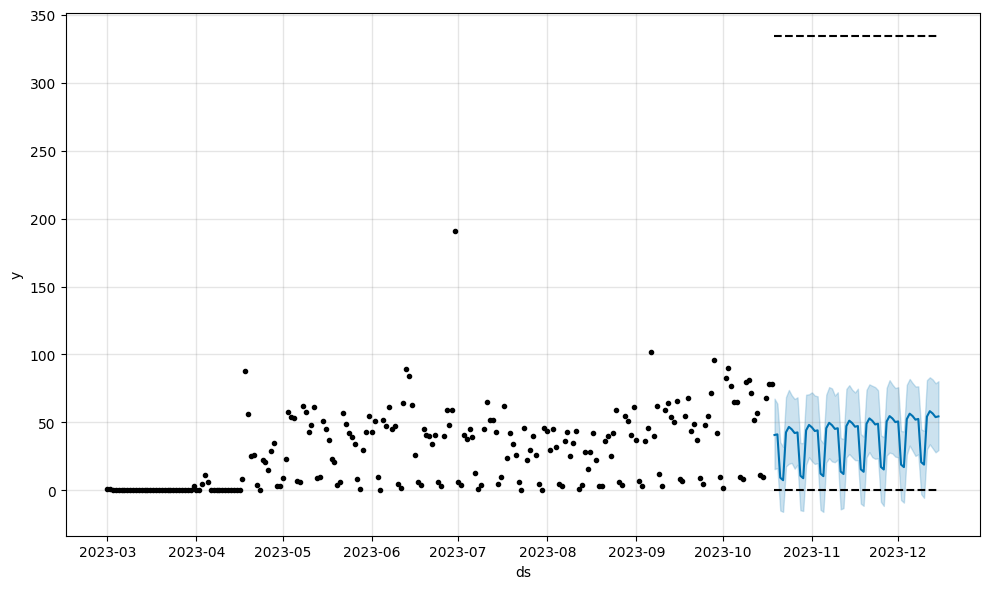

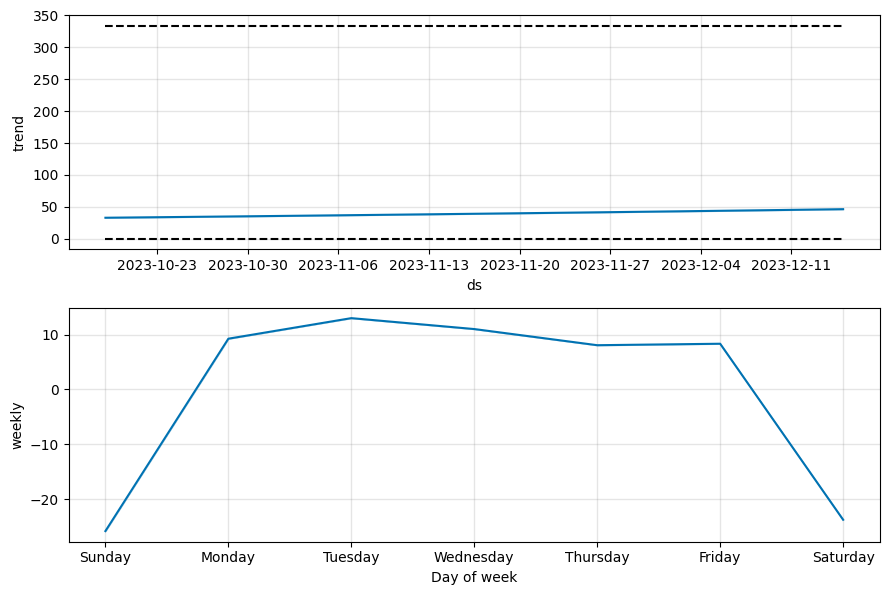

In [38]:
models_list = models_list_base  # List of trained models
forecast_list = forecast_list_base  # List of forecast results

# Iterate through the models and forecasts
for i in range(len(models_list)):
    print(i)

    # Plot the forecast for the current model
    models_list[i].plot(forecast_list[i])

    # Plot the components of the forecast for the current model
    models_list[i].plot_components(forecast_list[i])


### 9.2 Priority Wise Models

0
1
2
3
4


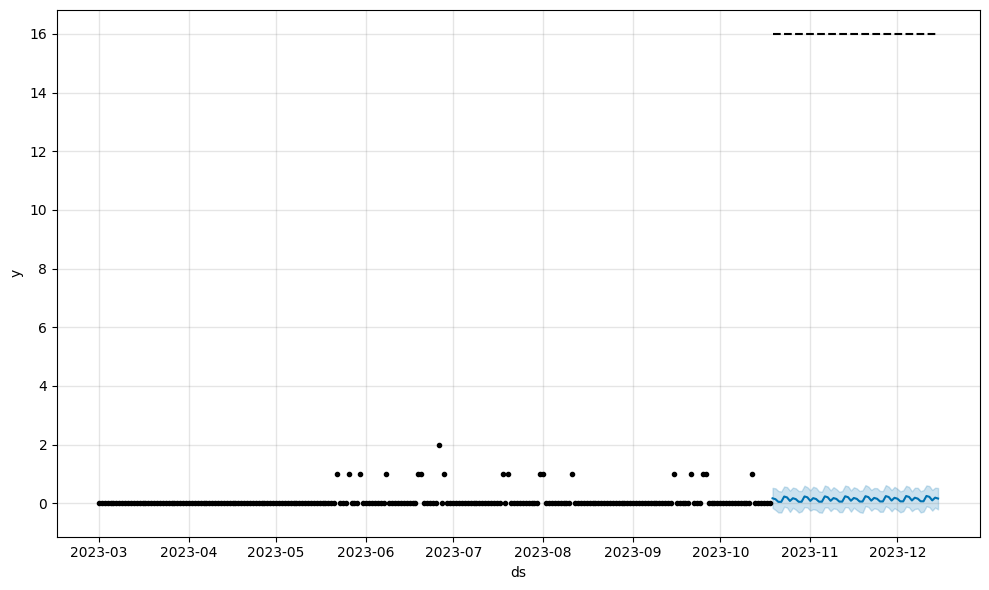

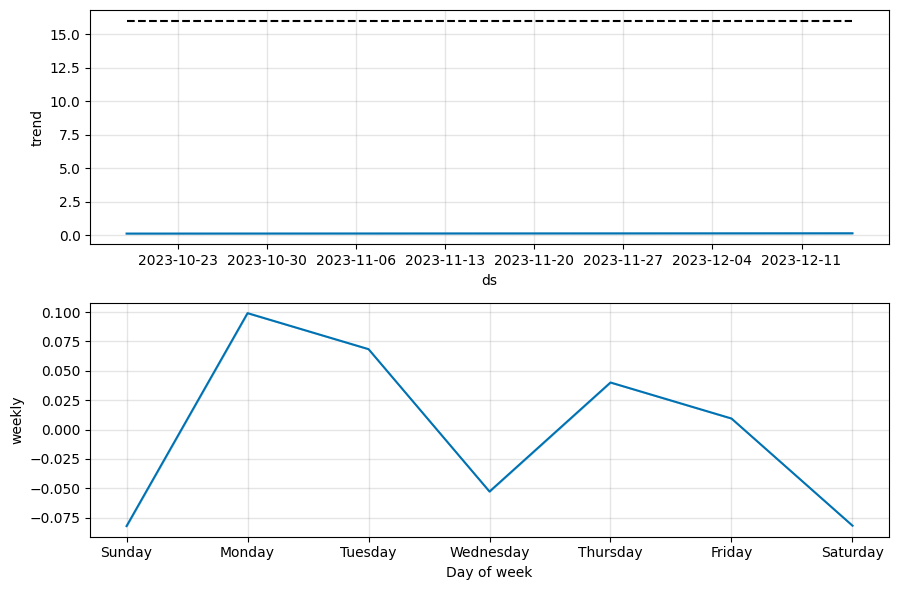

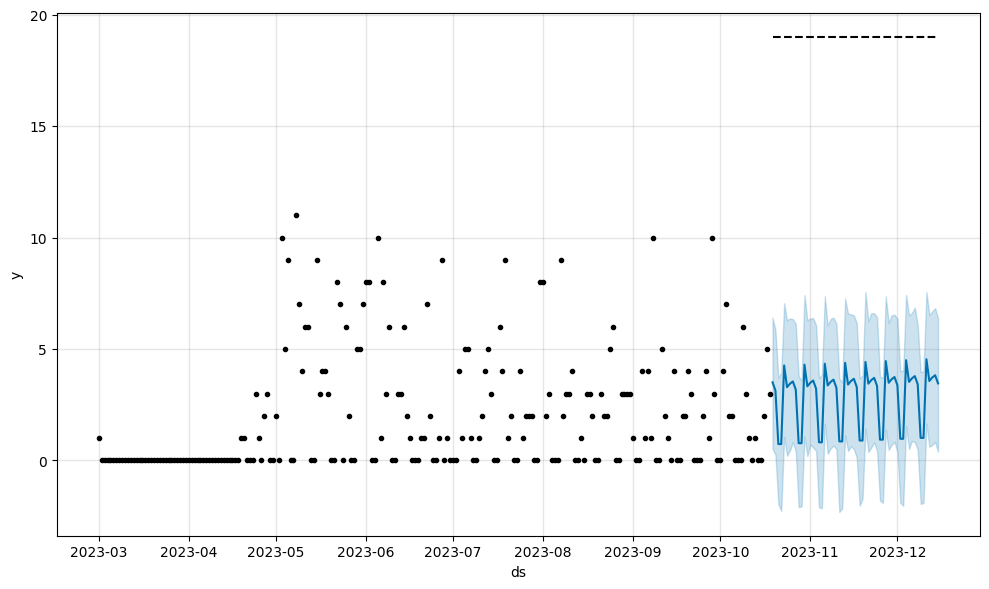

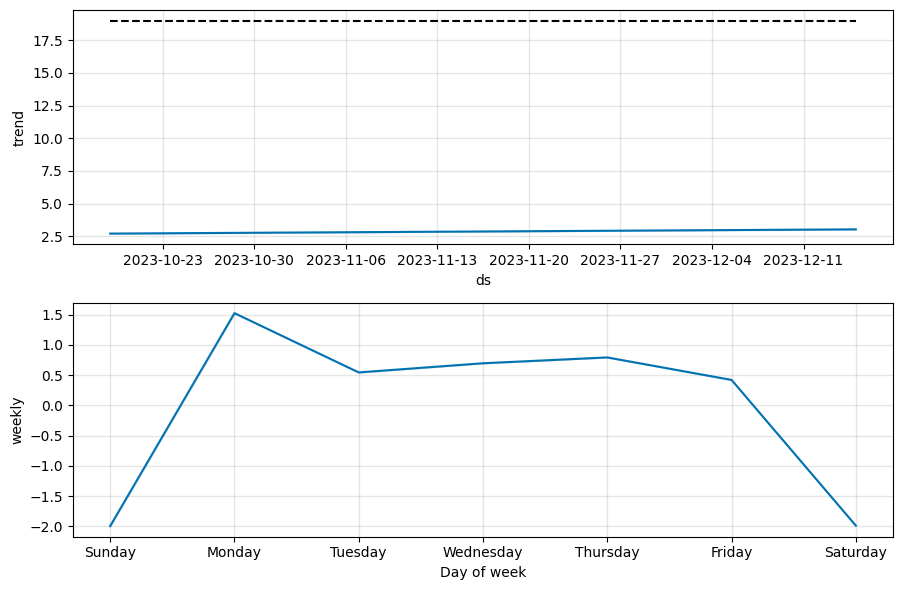

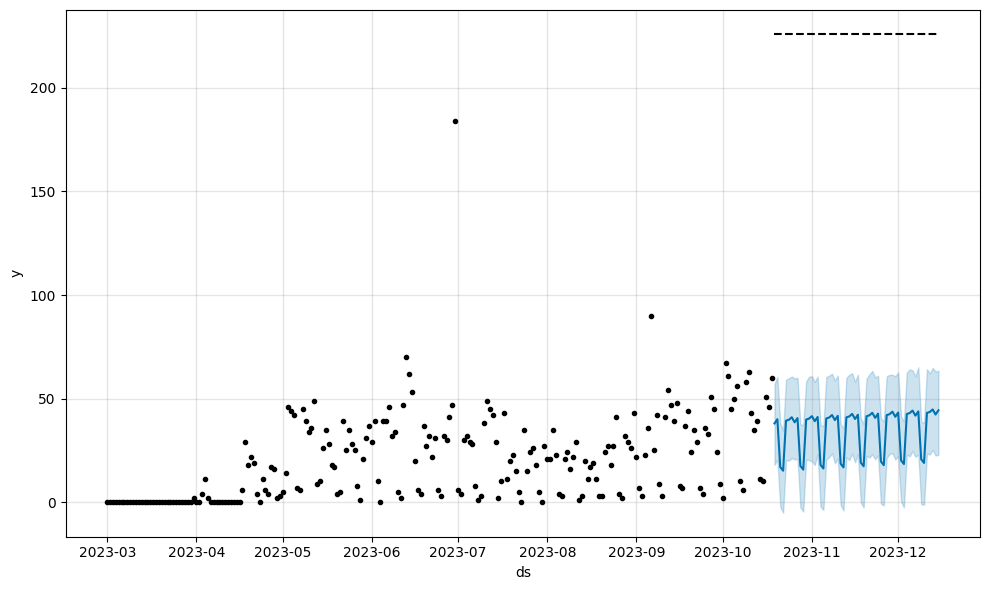

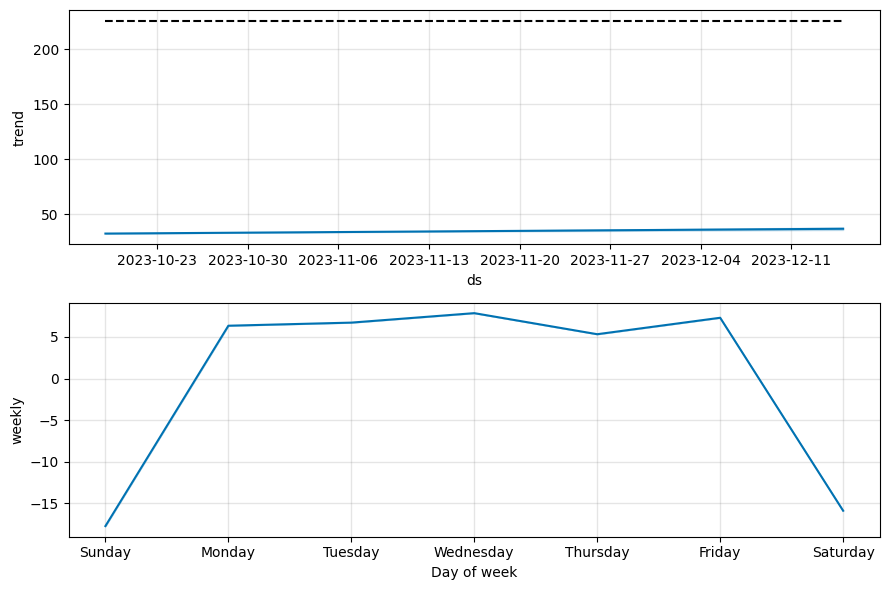

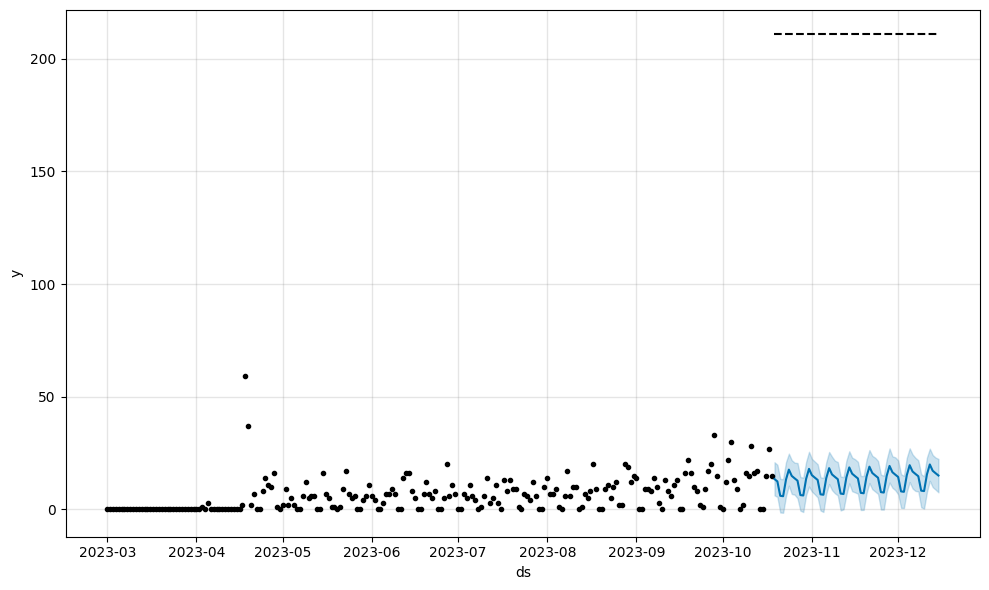

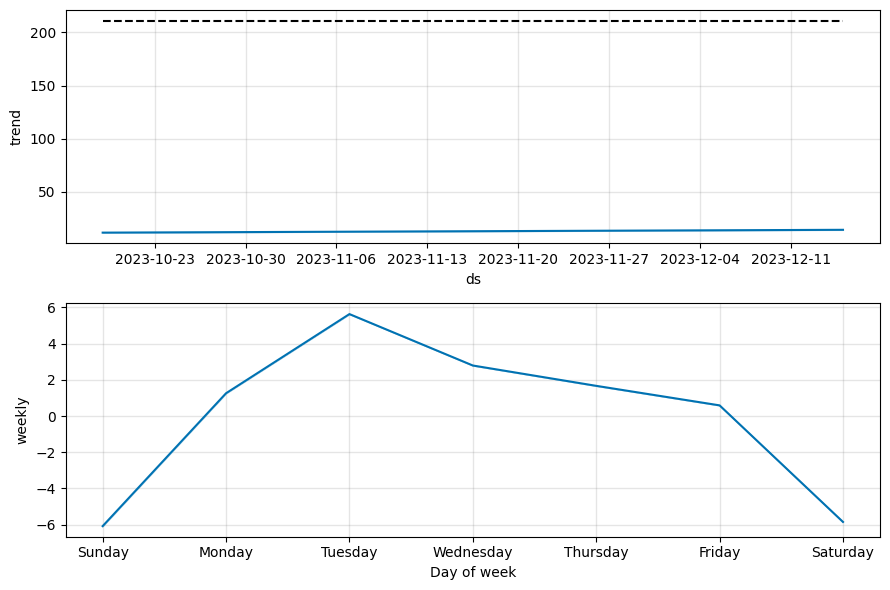

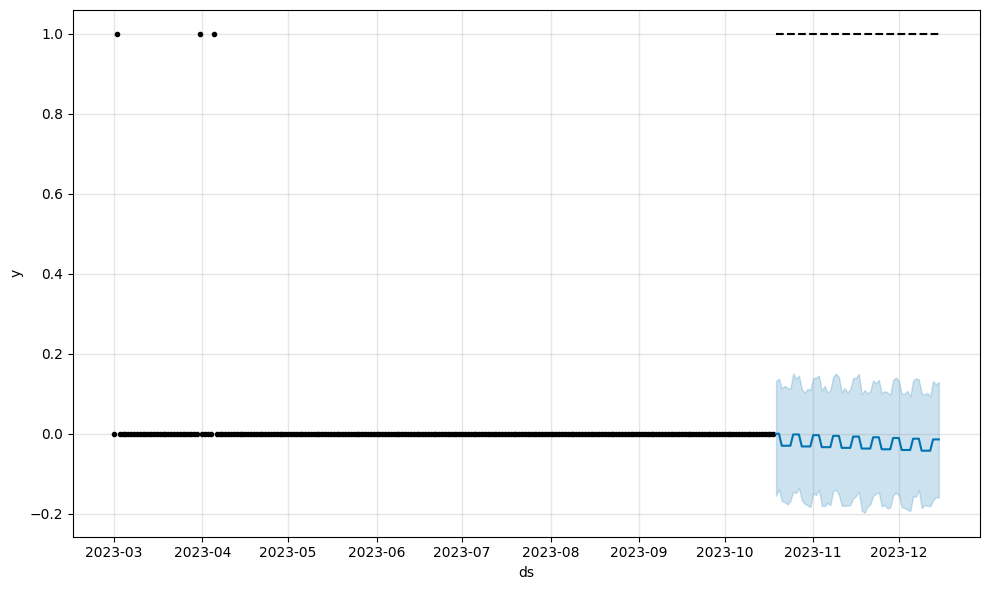

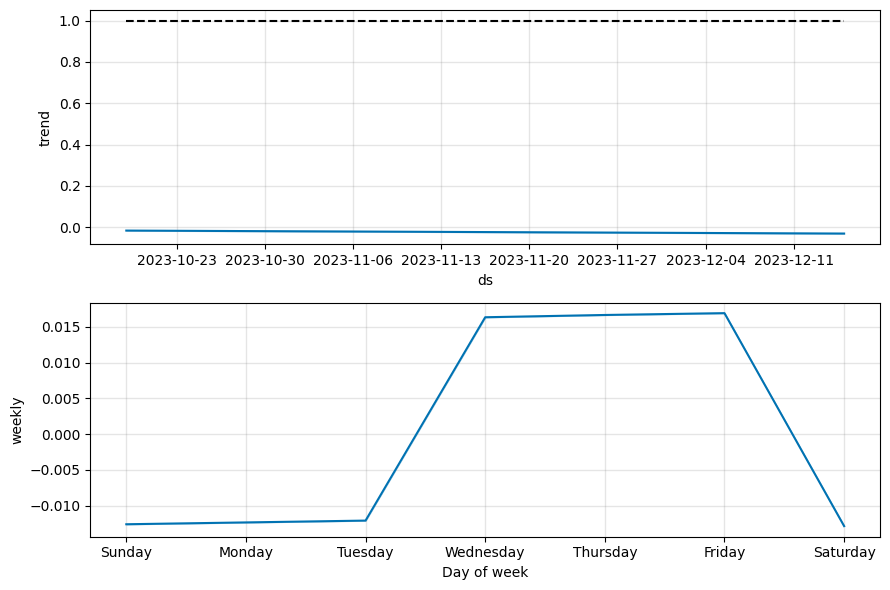

In [39]:
models_list = models_list_priority_wise  # List of trained models
forecast_list = forecast_list_priority_wise  # List of forecast results

# Iterate through the models and forecasts
for i in range(len(models_list)):
    print(i)

    # Plot the forecast for the current model
    models_list[i].plot(forecast_list[i])

    # Plot the components of the forecast for the current model
    models_list[i].plot_components(forecast_list[i])


### 9.3 Category Wise Models

0
1
2
3
4
5
6
7


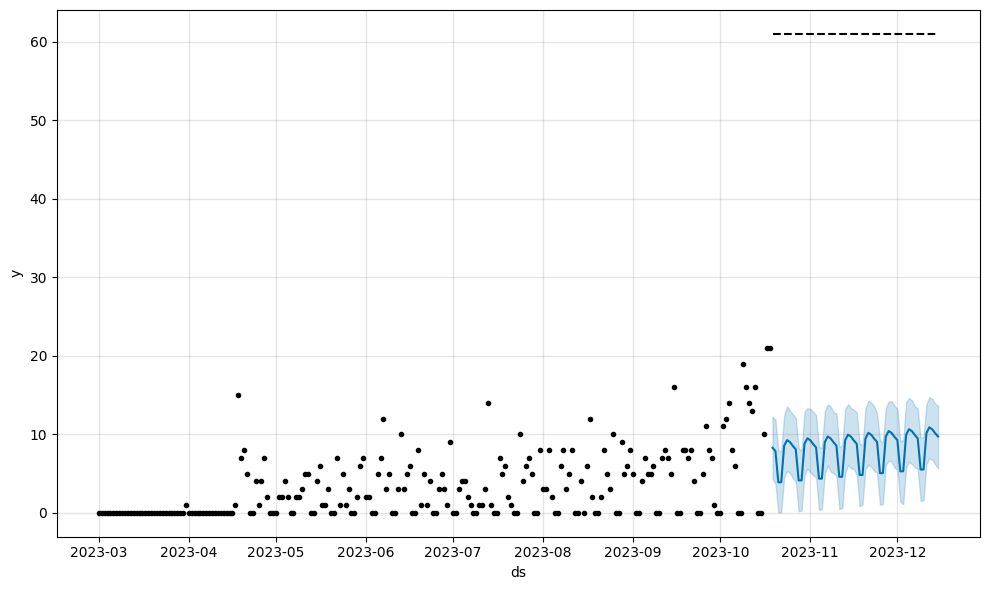

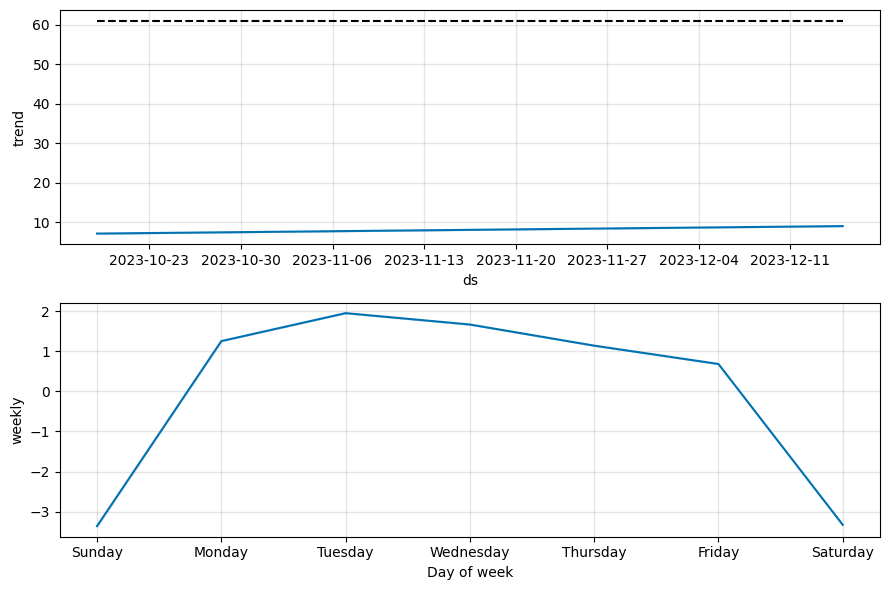

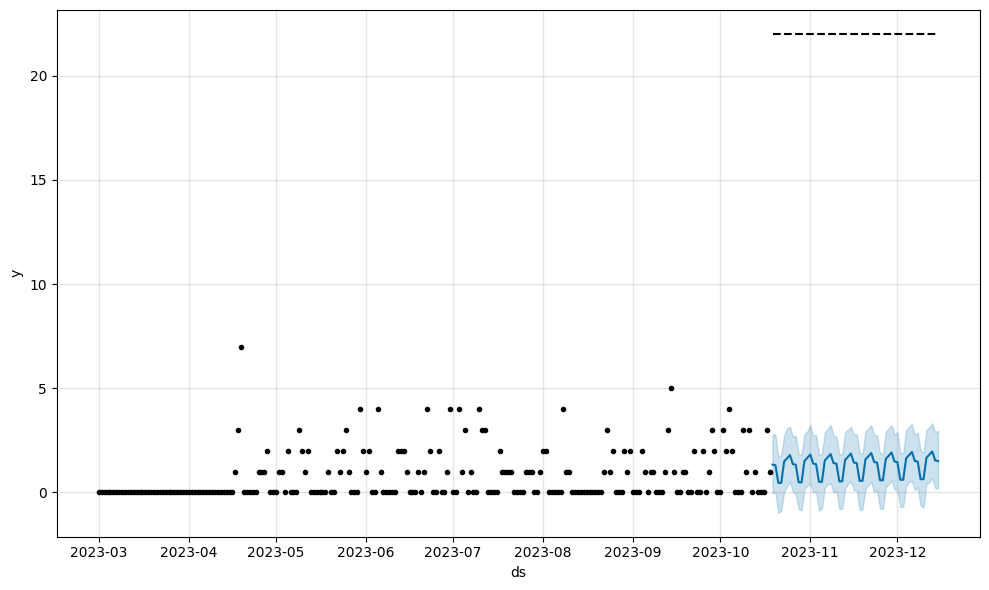

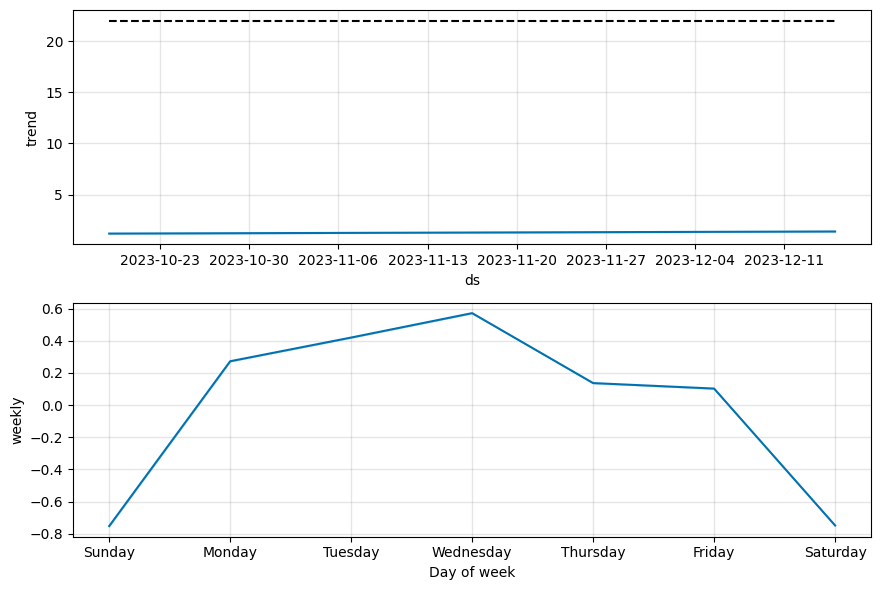

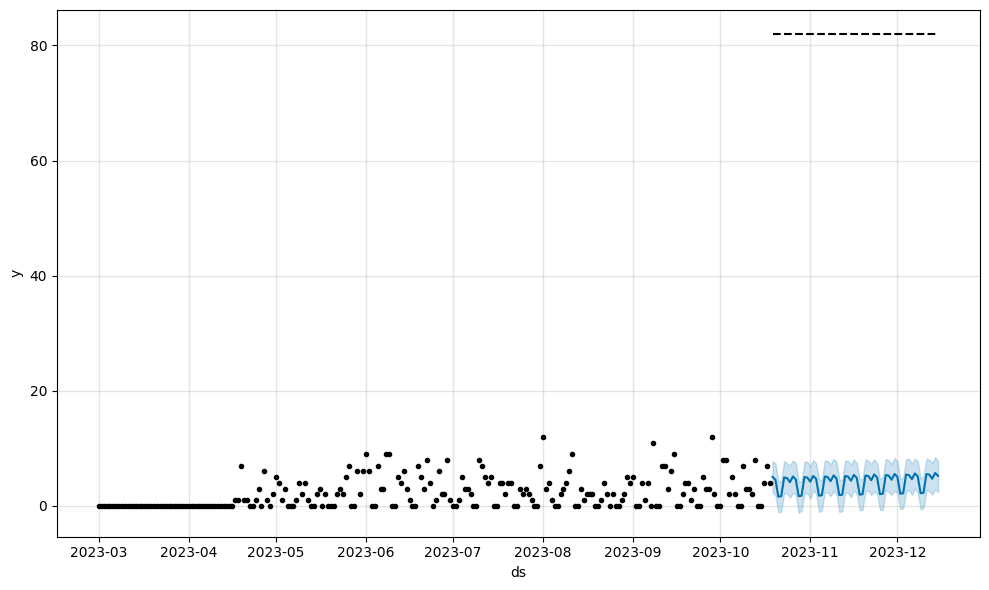

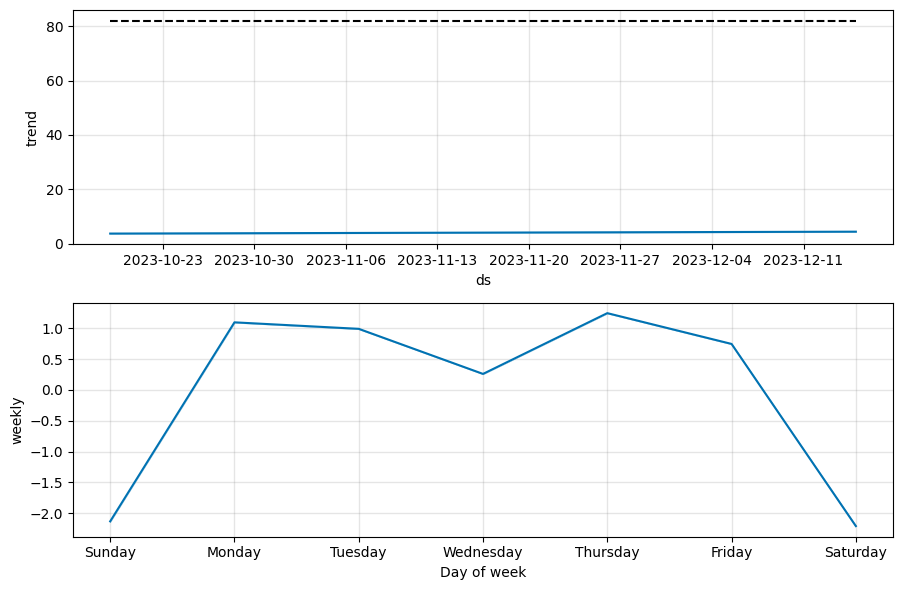

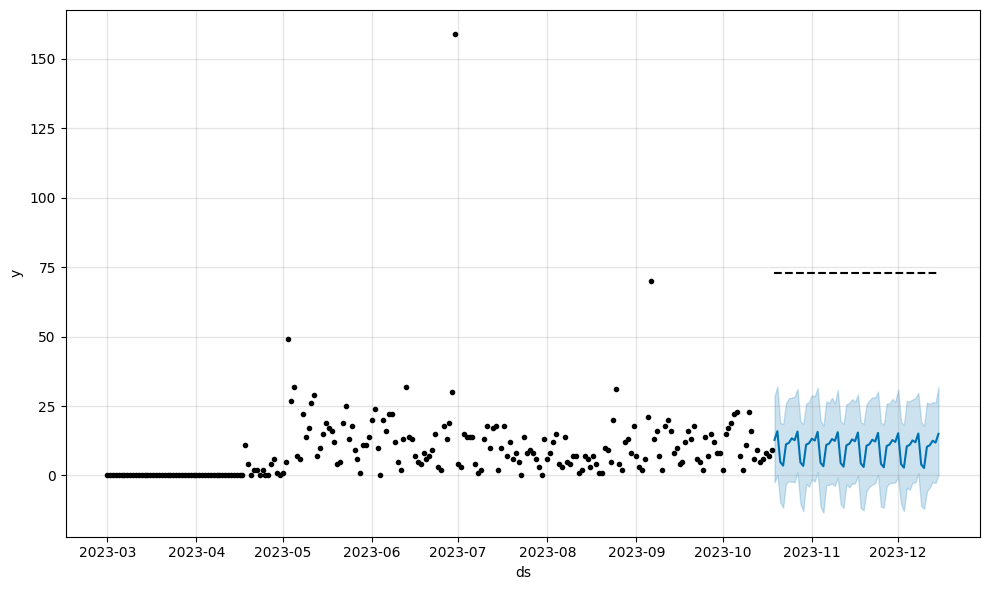

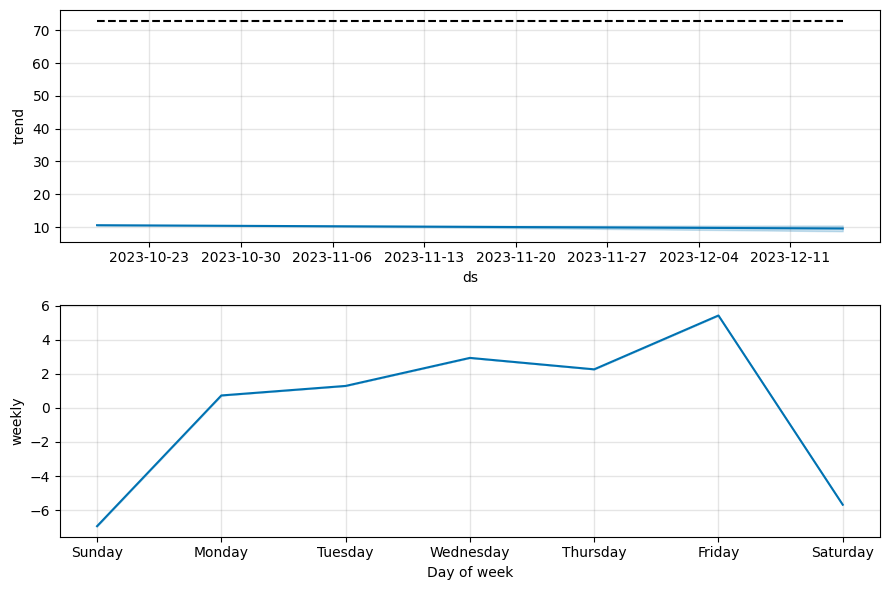

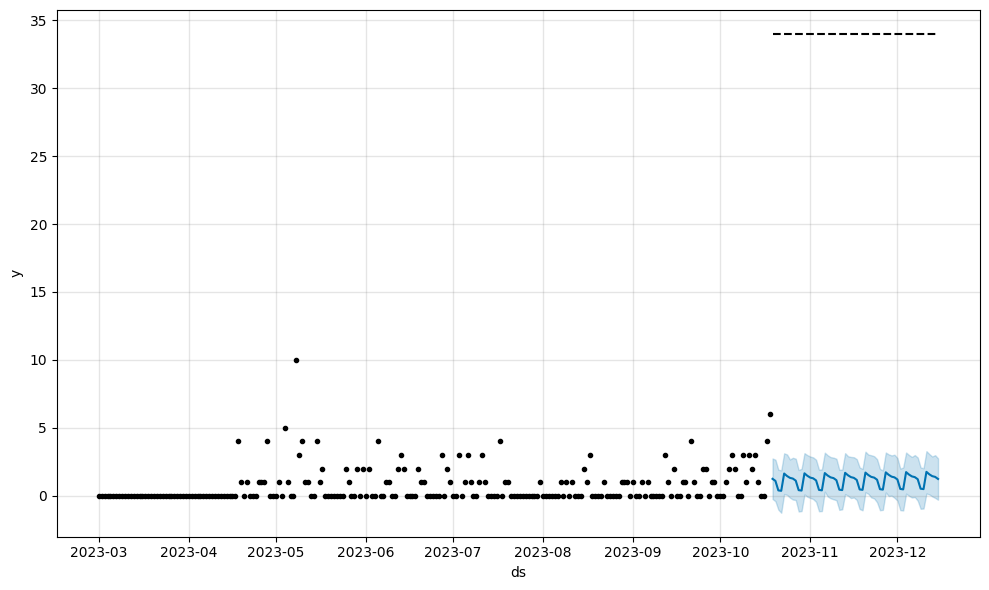

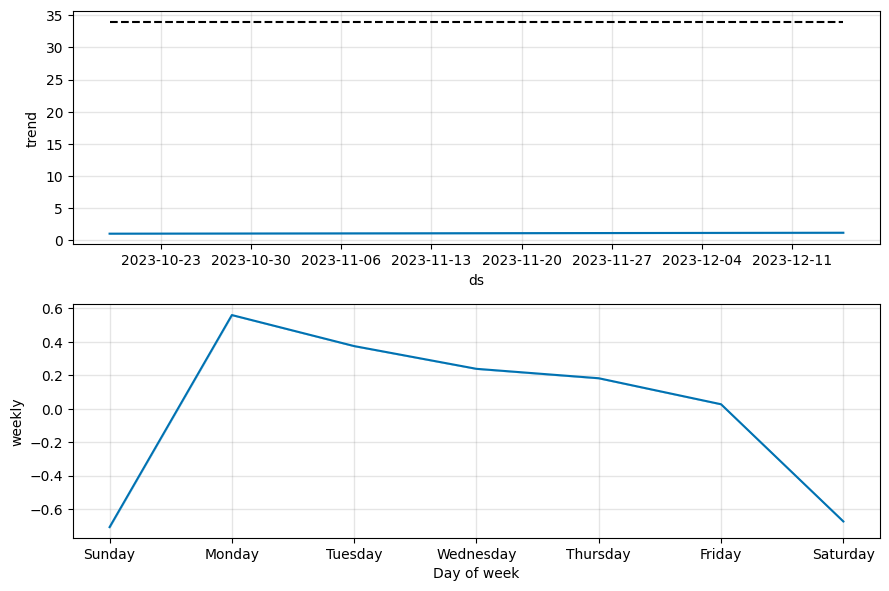

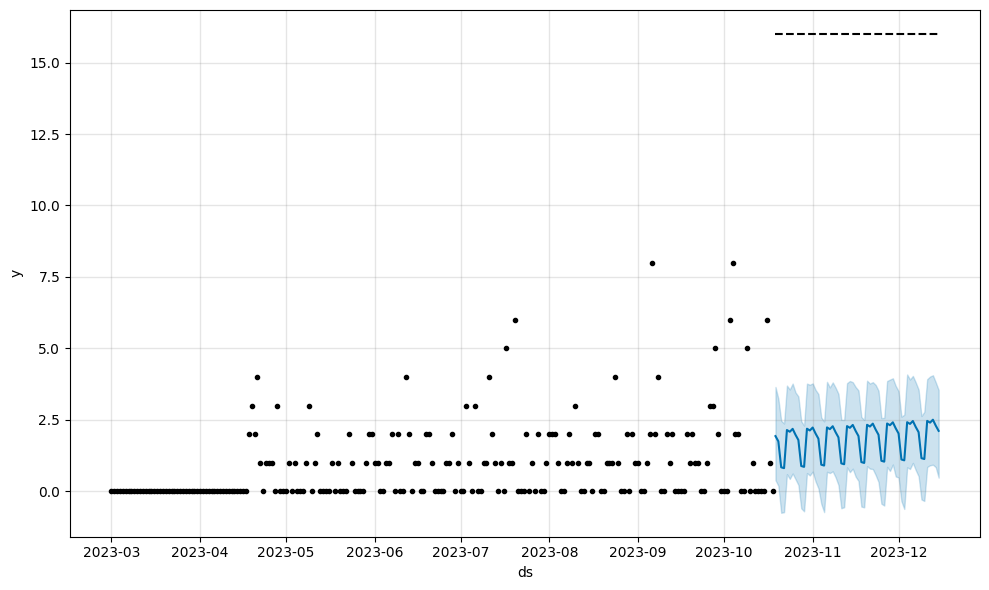

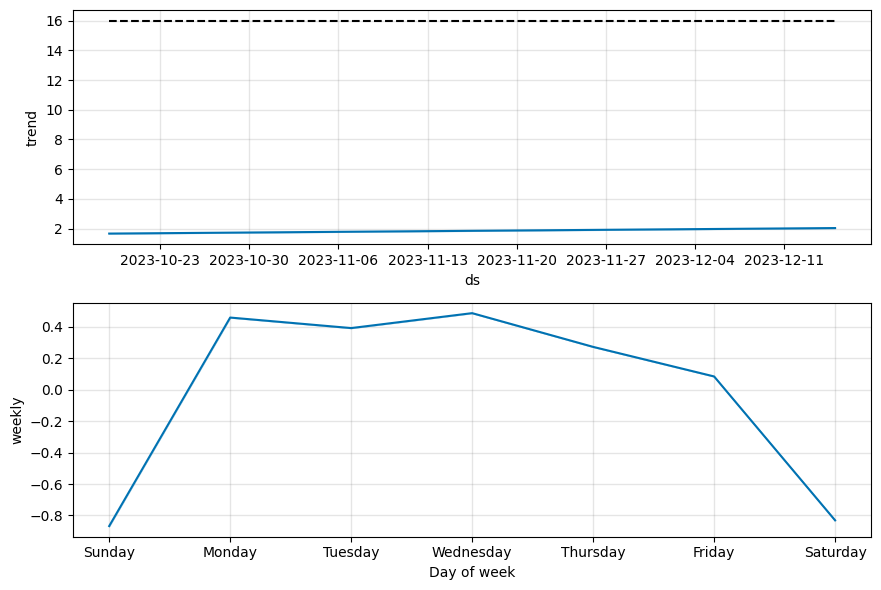

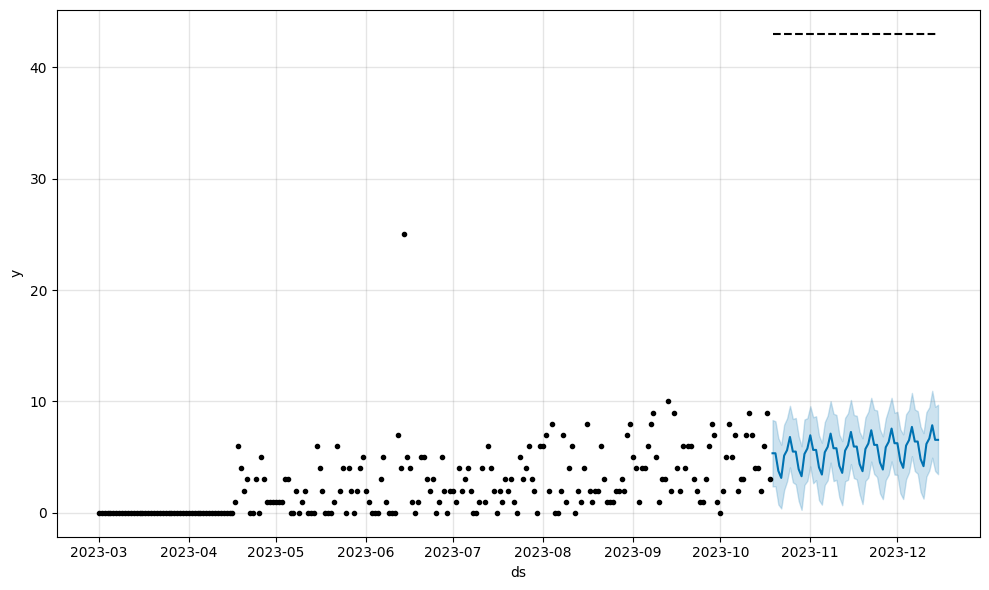

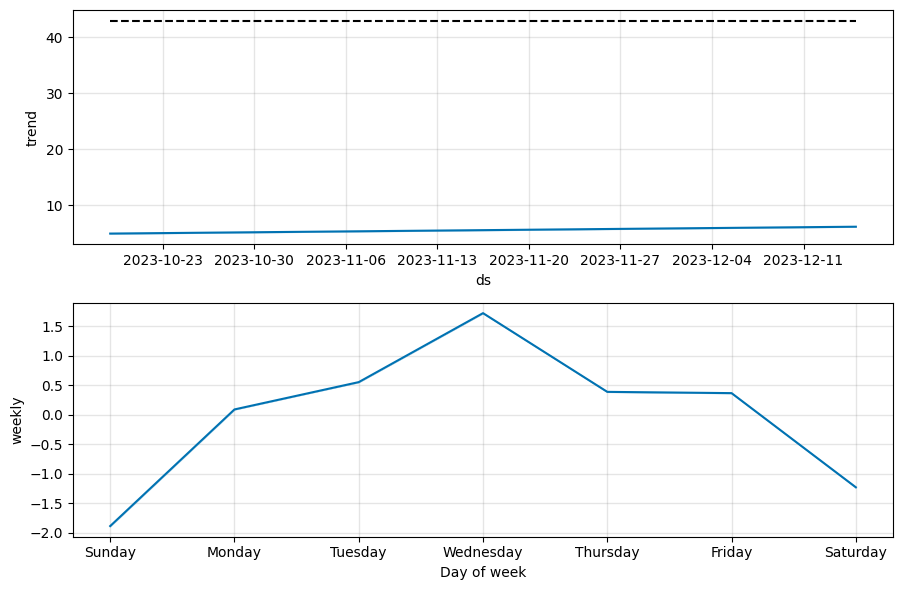

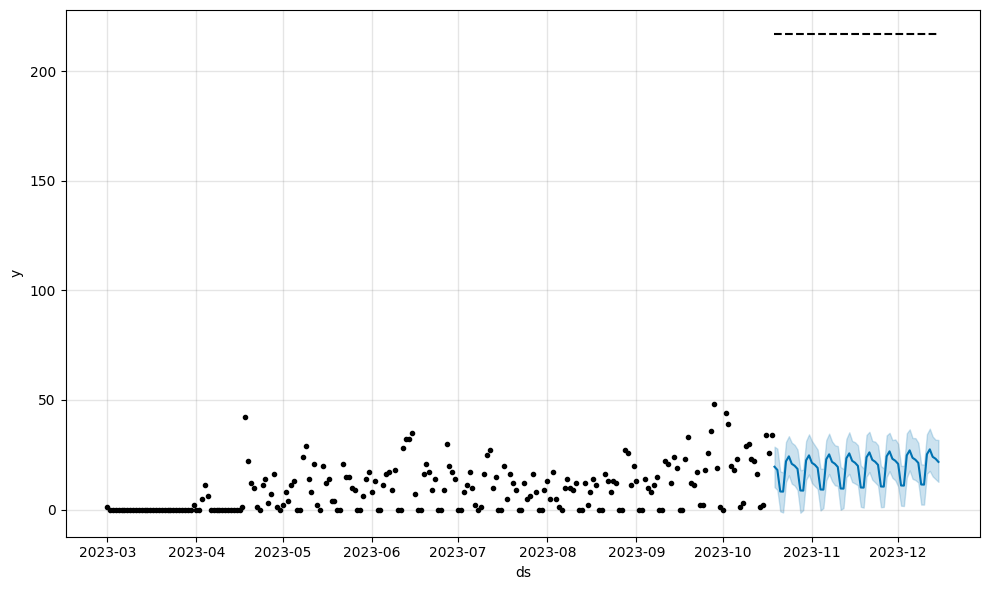

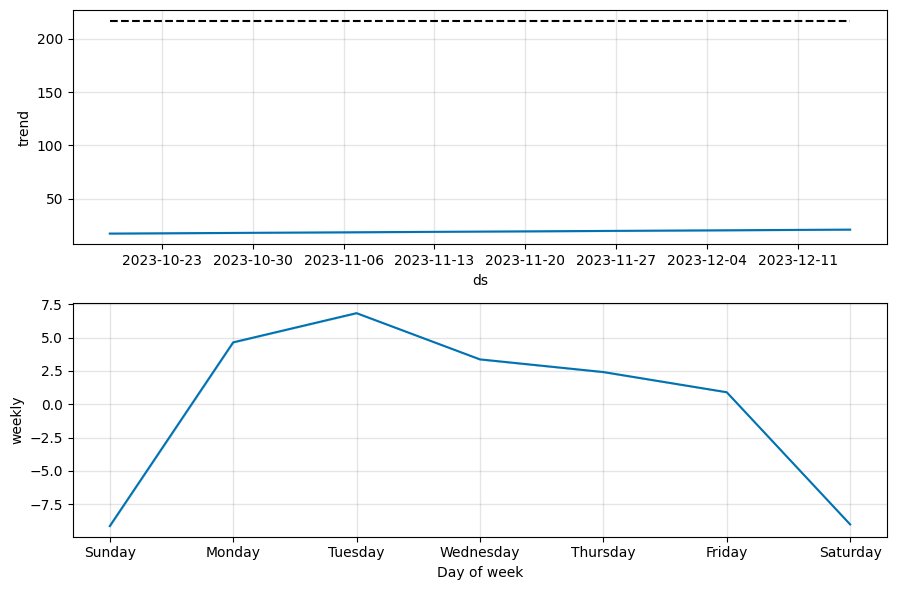

In [40]:
models_list = models_list_category_wise  # List of trained models
forecast_list = forecast_list_category_wise  # List of forecast results

# Iterate through the models and forecasts
for i in range(len(models_list)):
    print(i)

    # Plot the forecast for the current model
    models_list[i].plot(forecast_list[i])

    # Plot the components of the forecast for the current model
    models_list[i].plot_components(forecast_list[i])


### 9.4 Category-Priority Wise Models

0
1
2
3
4
5
6
7
8
9
10


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(facecolor='w', figsize=figsize)


11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


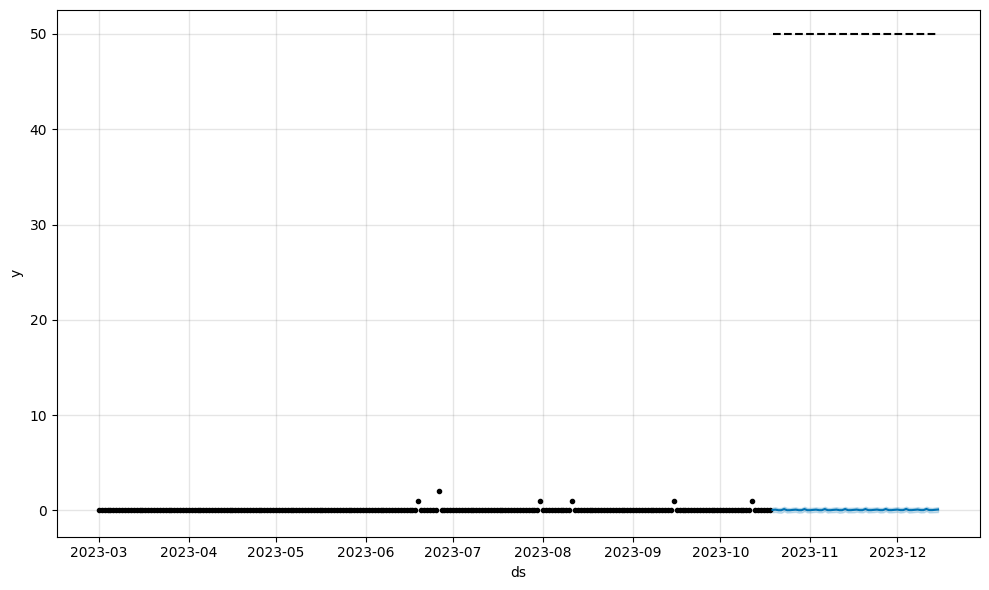

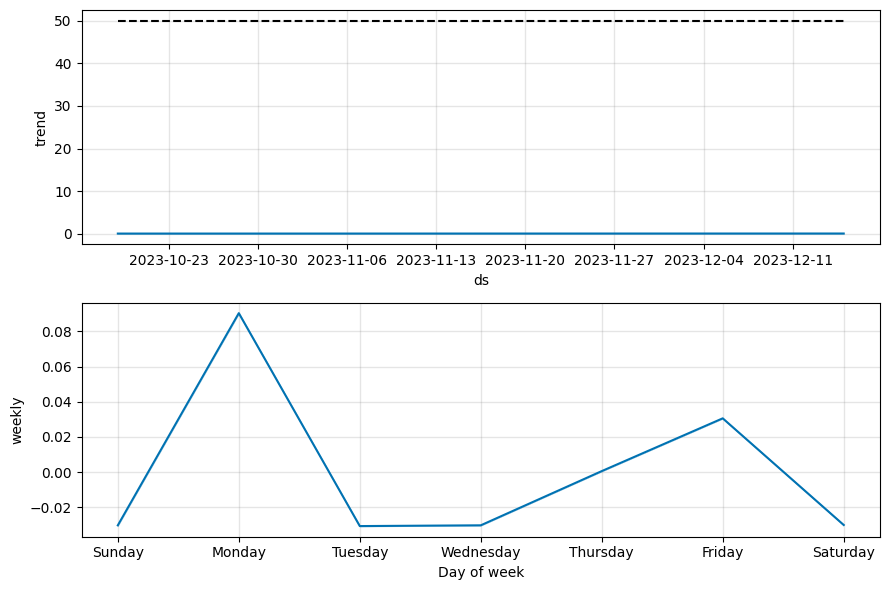

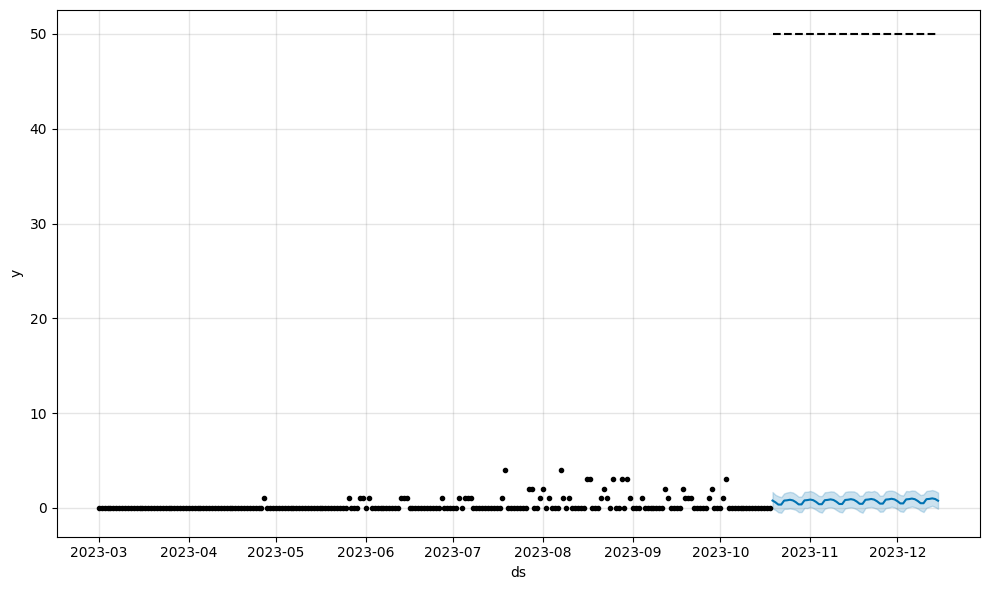

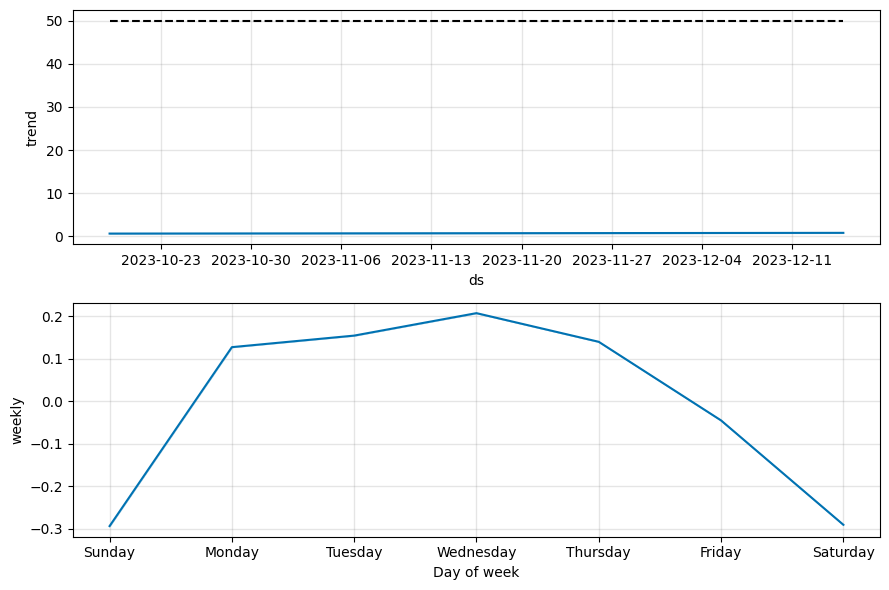

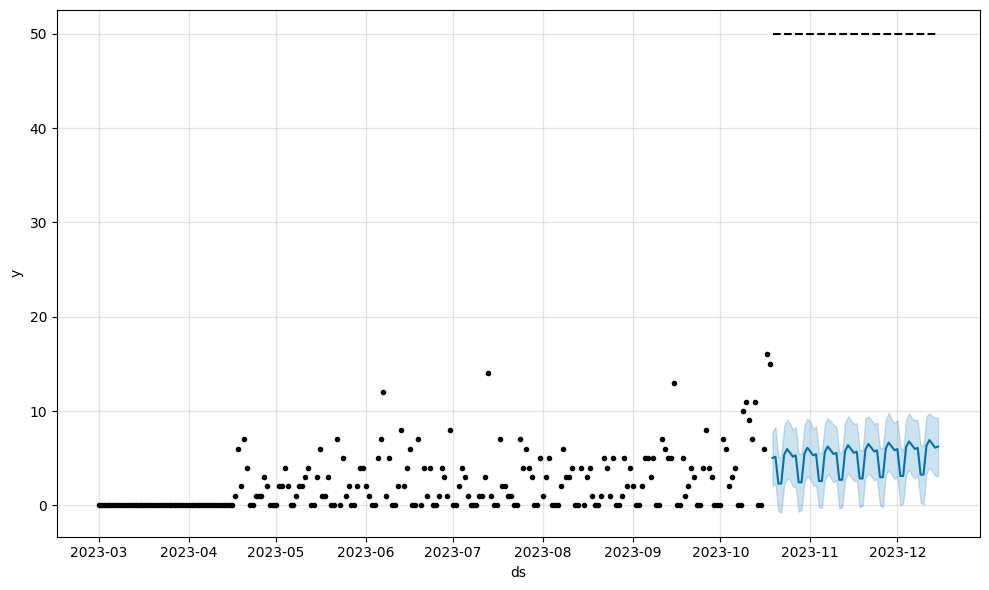

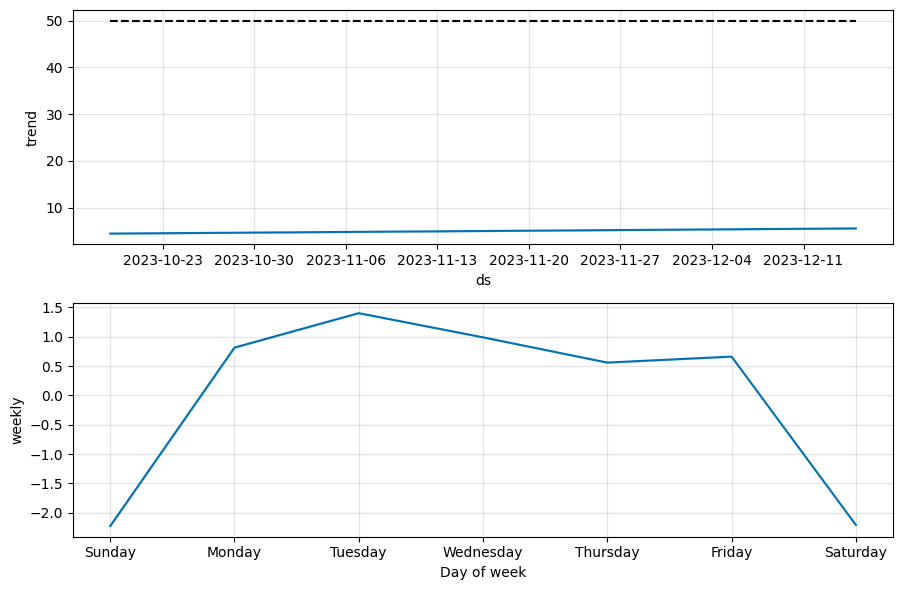

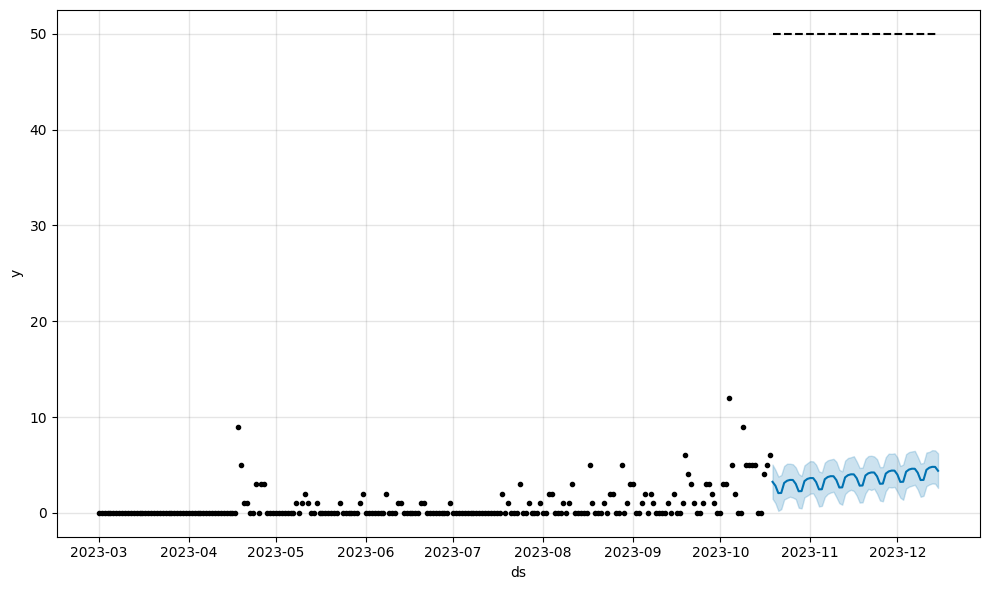

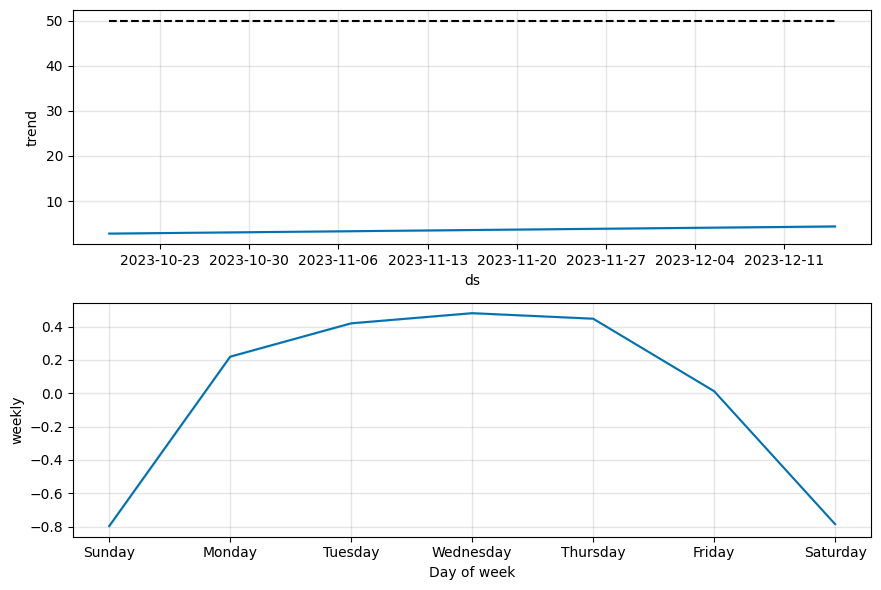

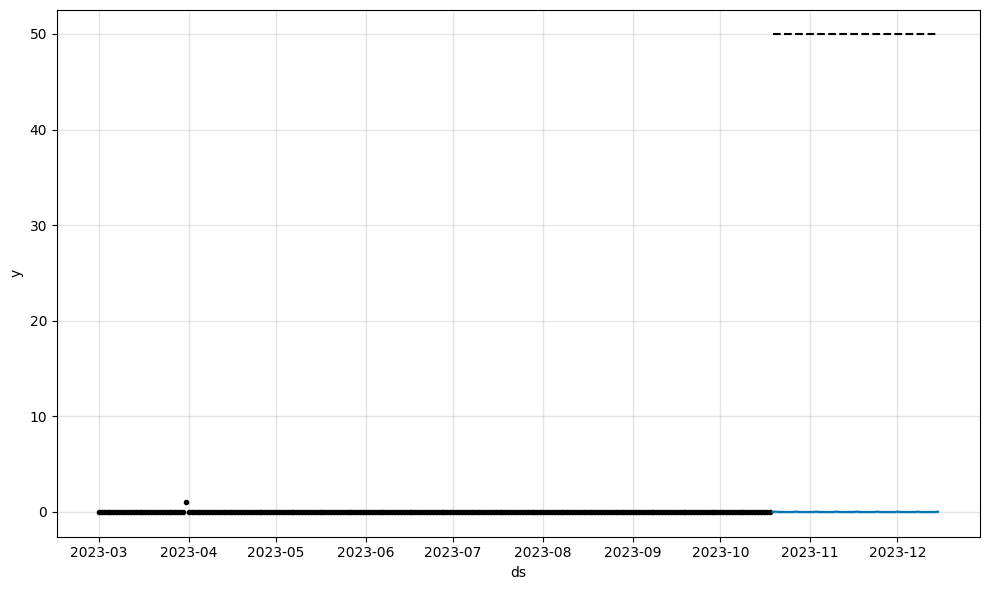

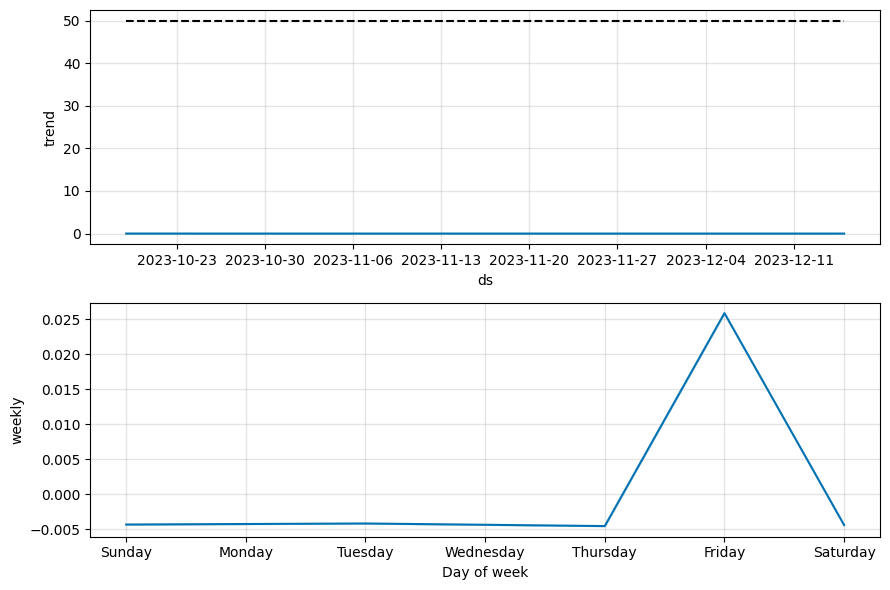

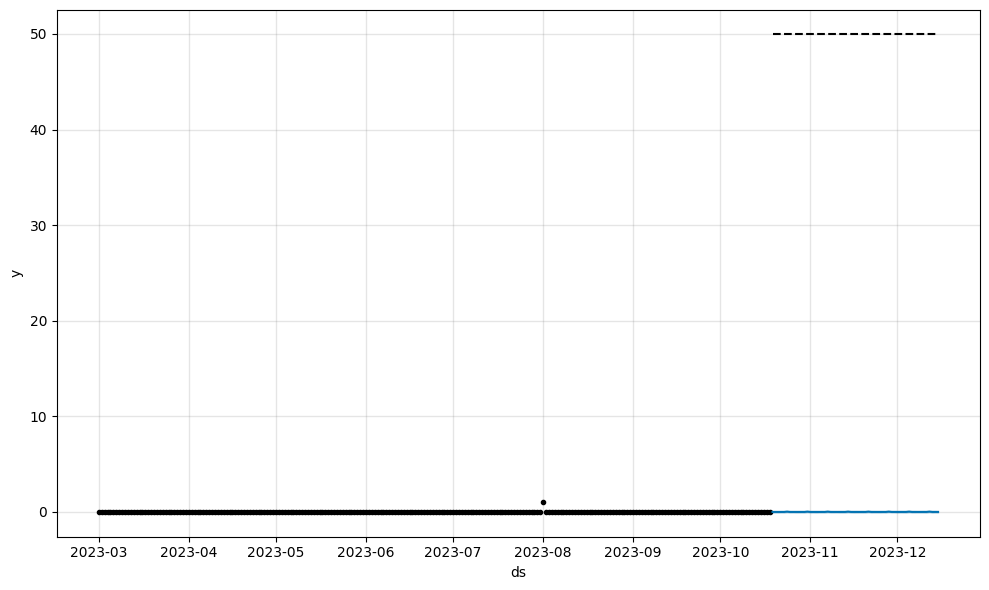

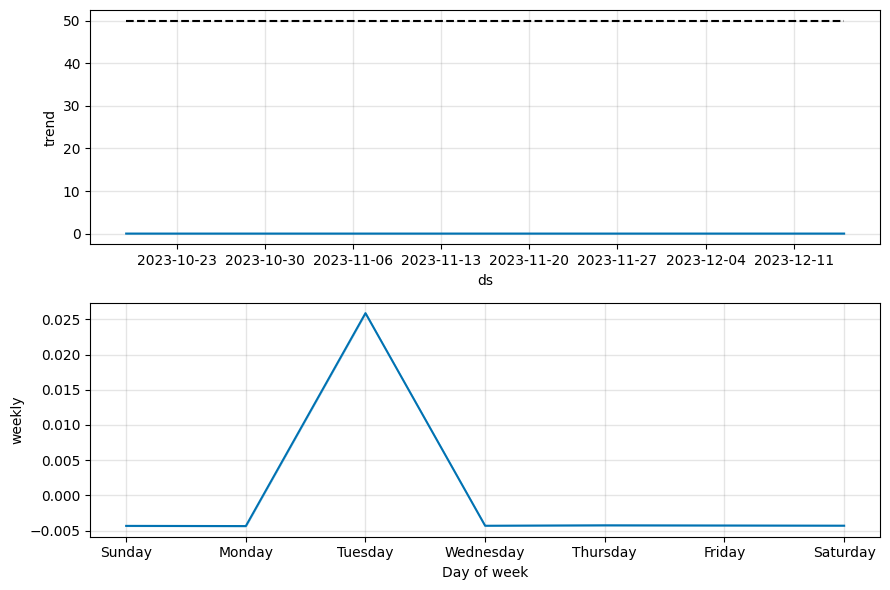

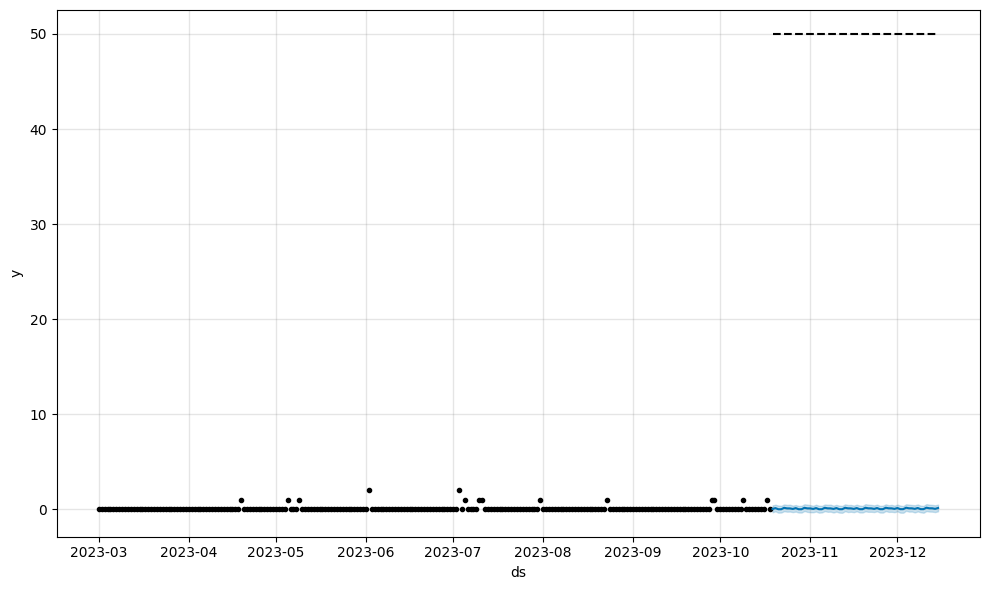

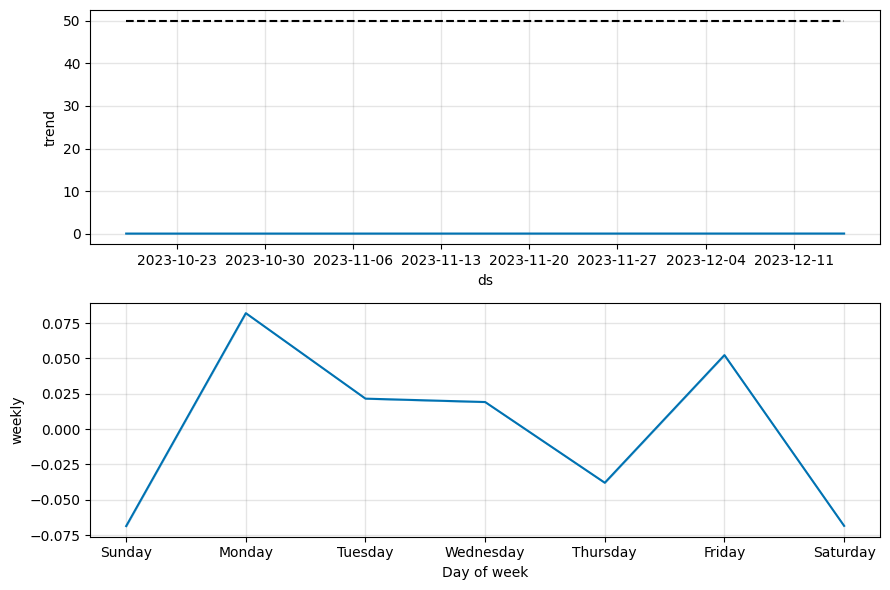

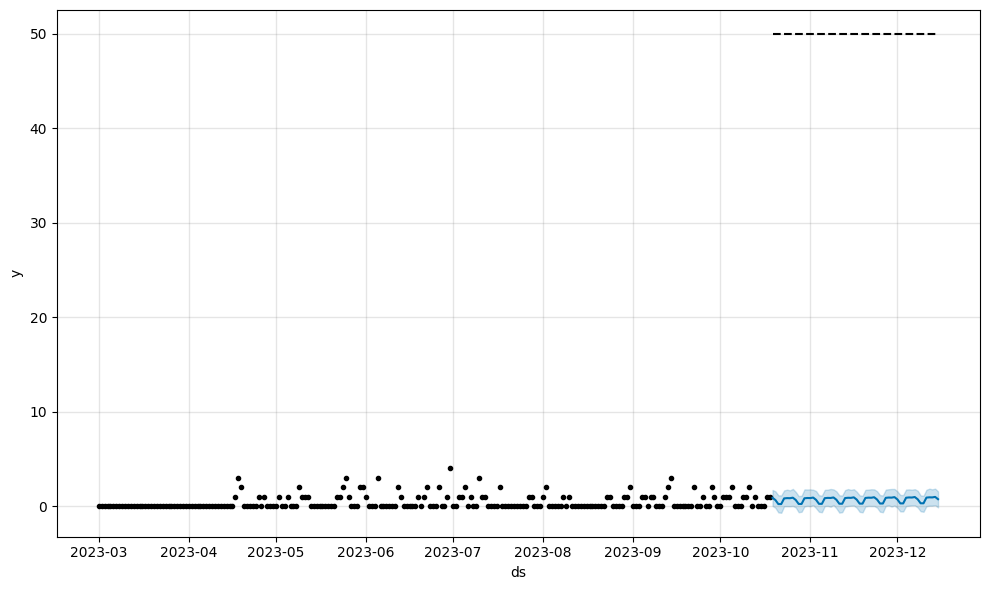

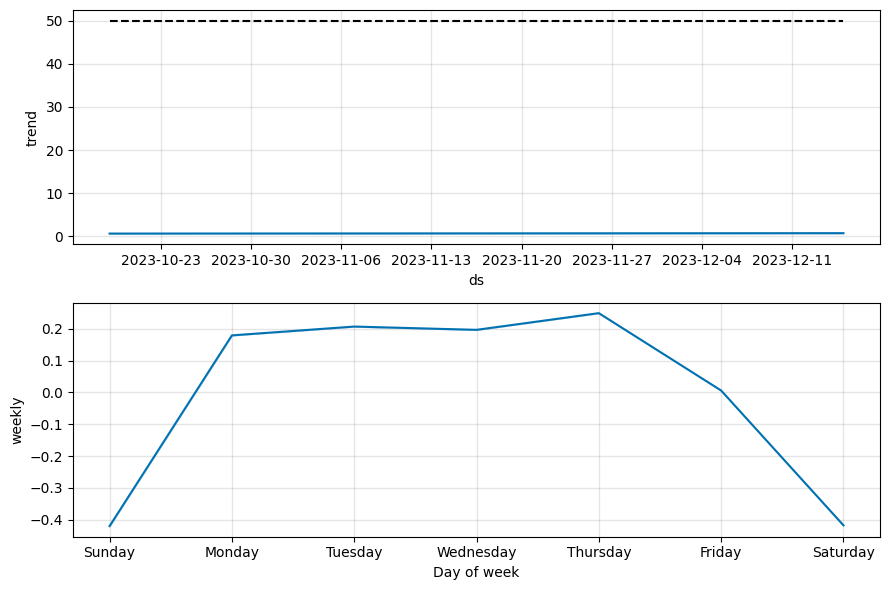

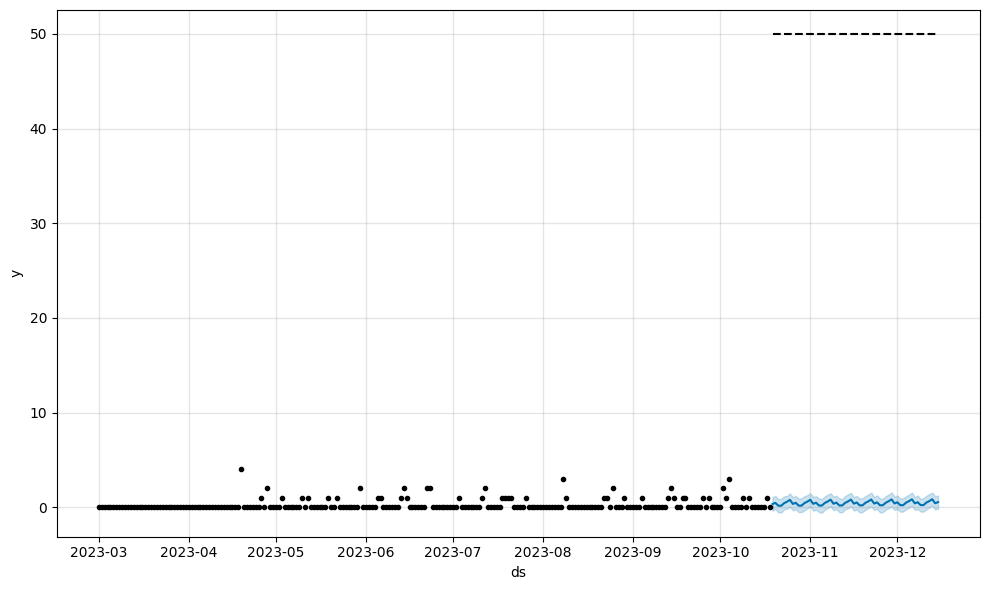

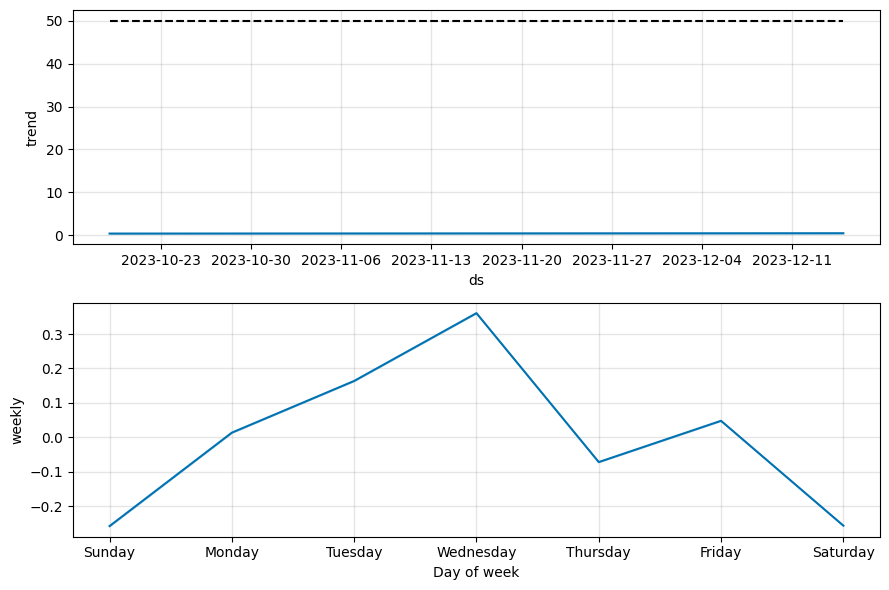

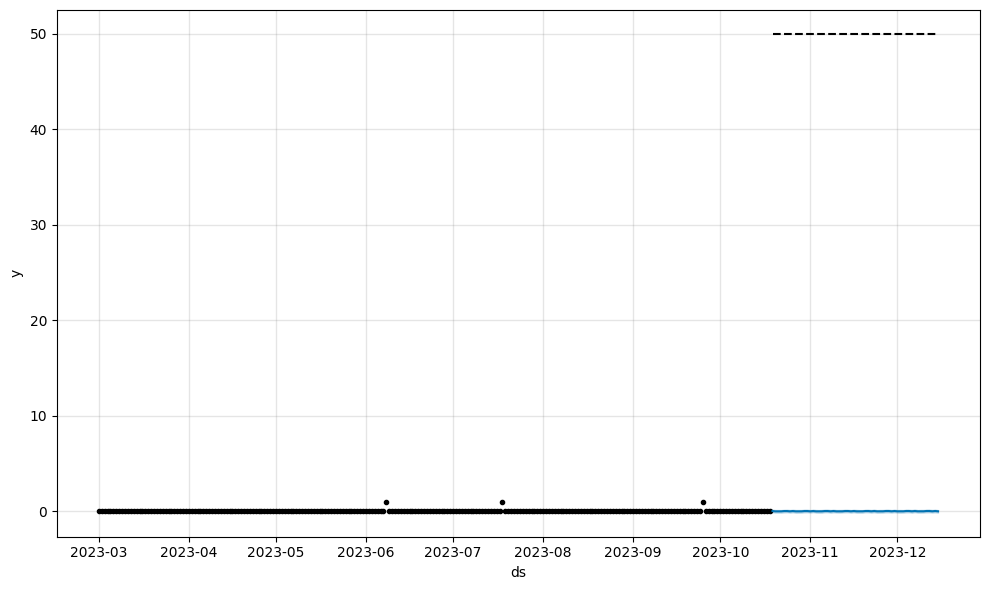

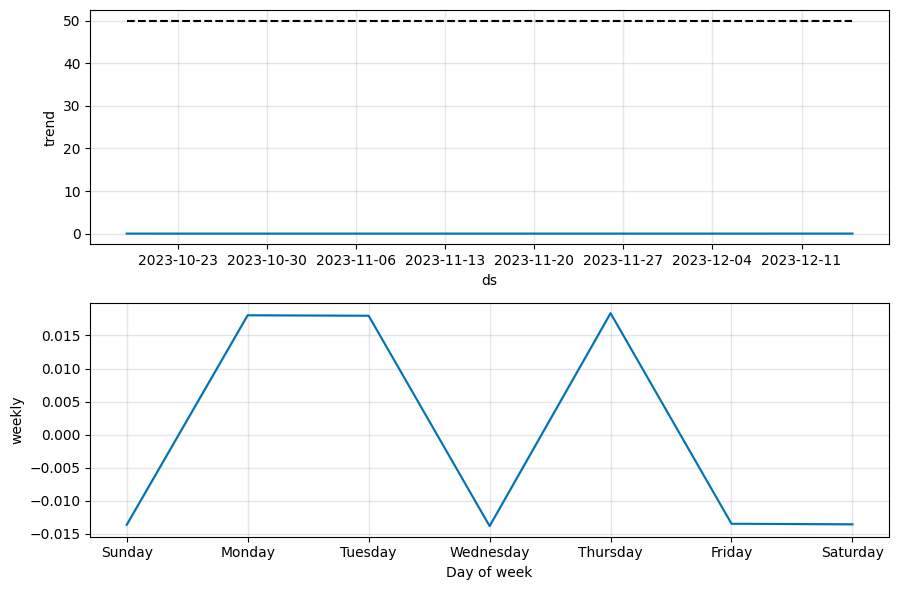

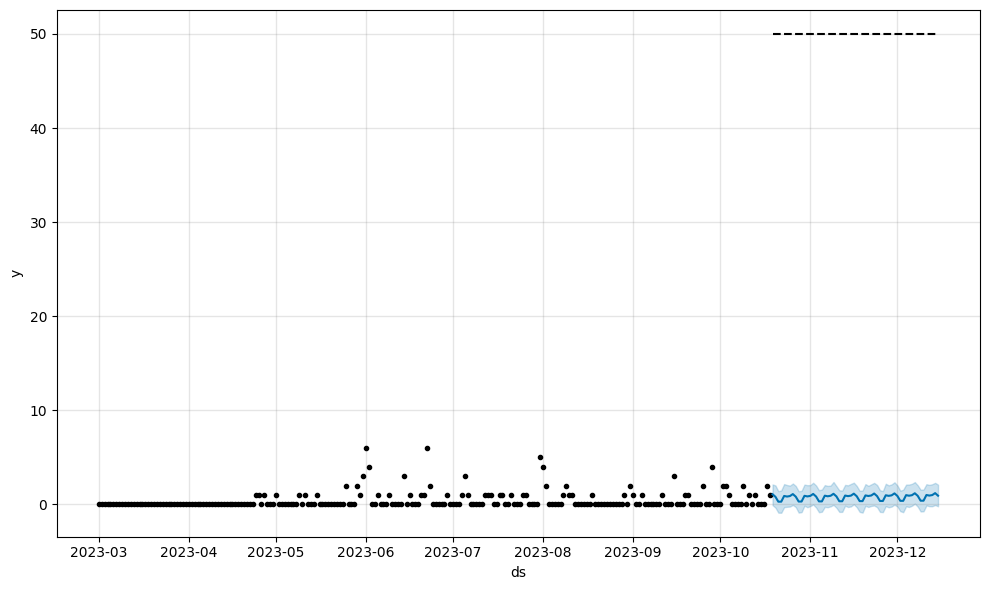

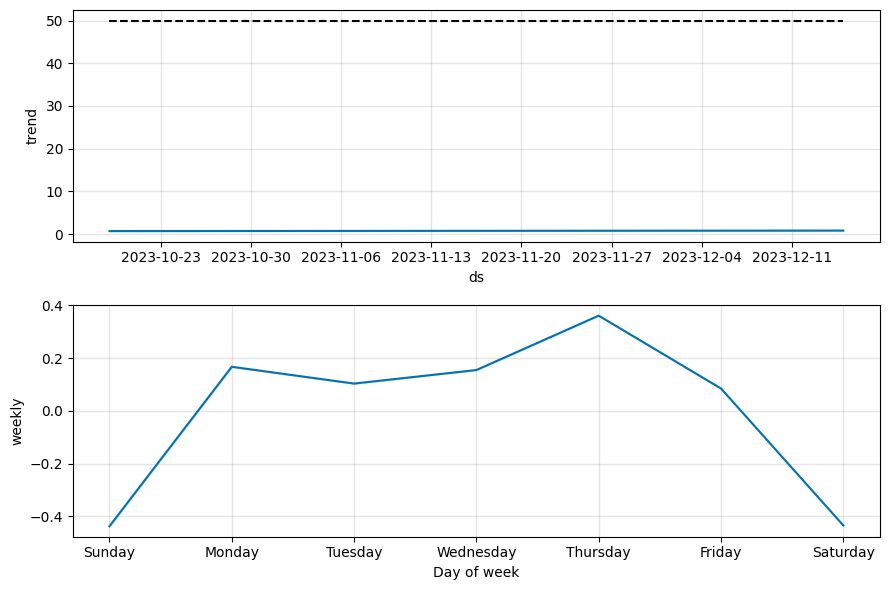

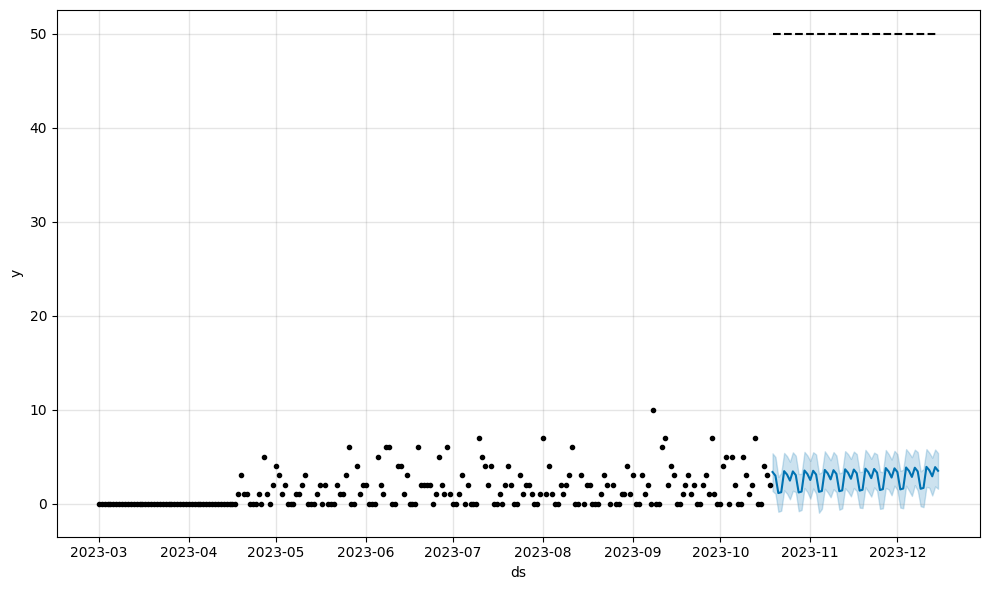

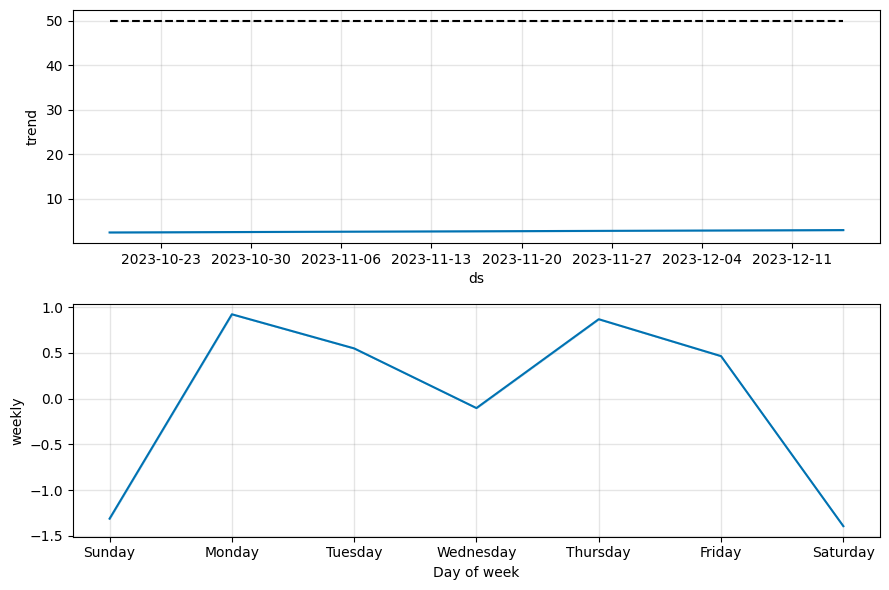

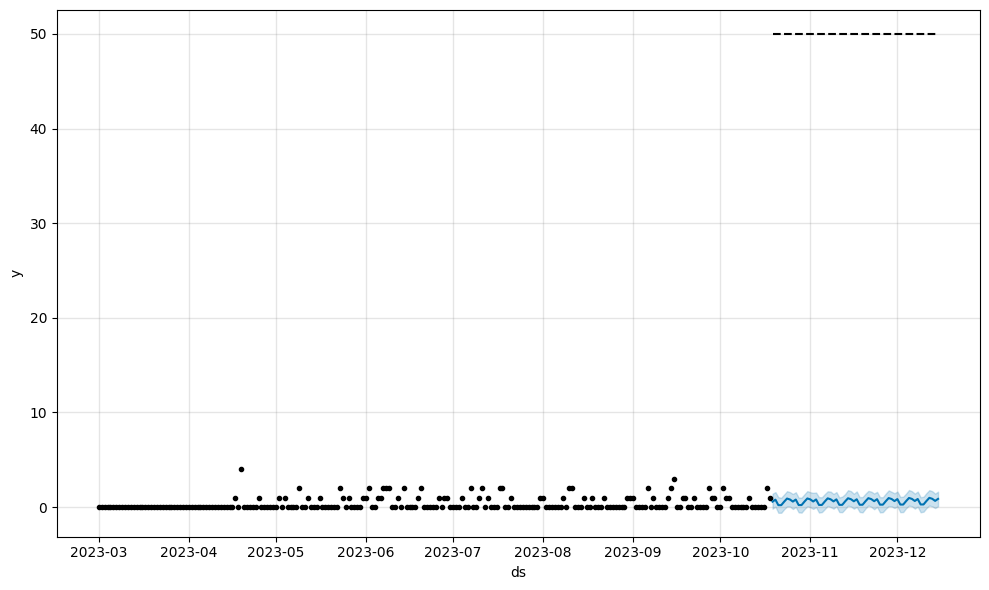

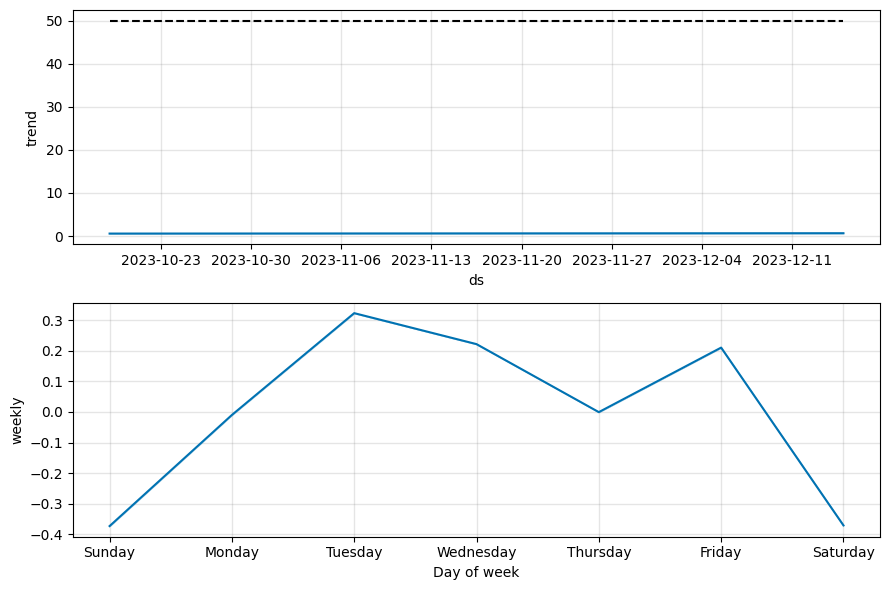

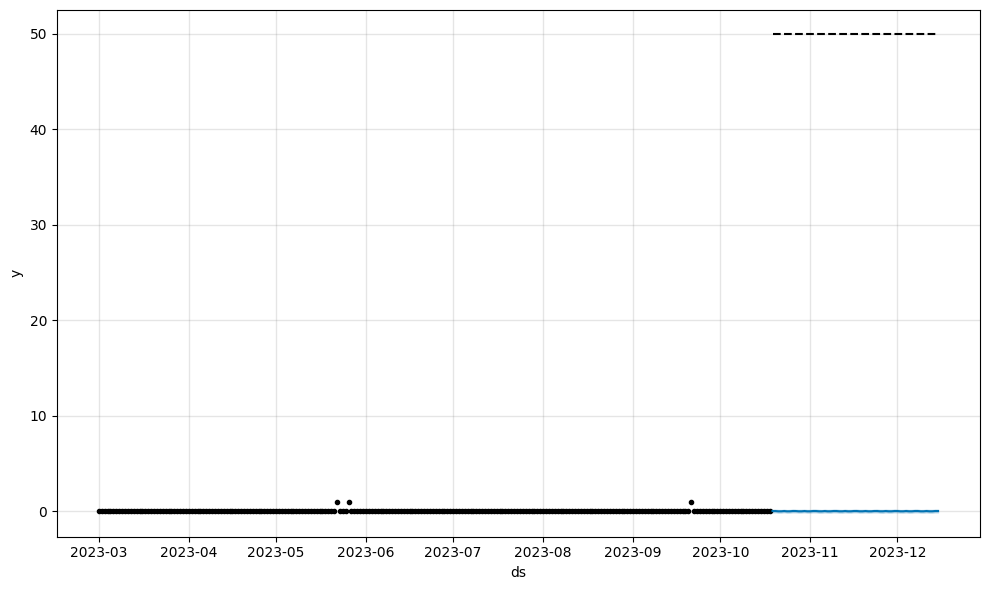

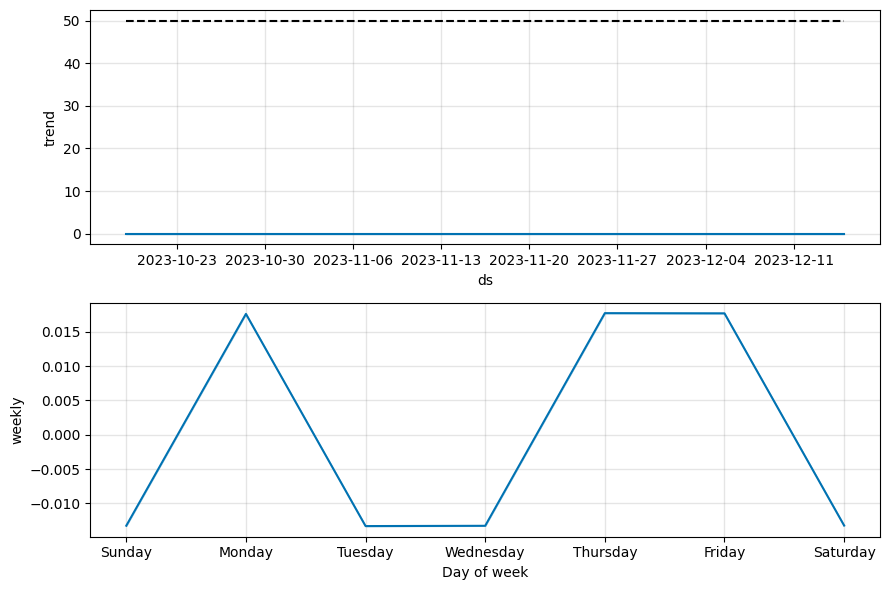

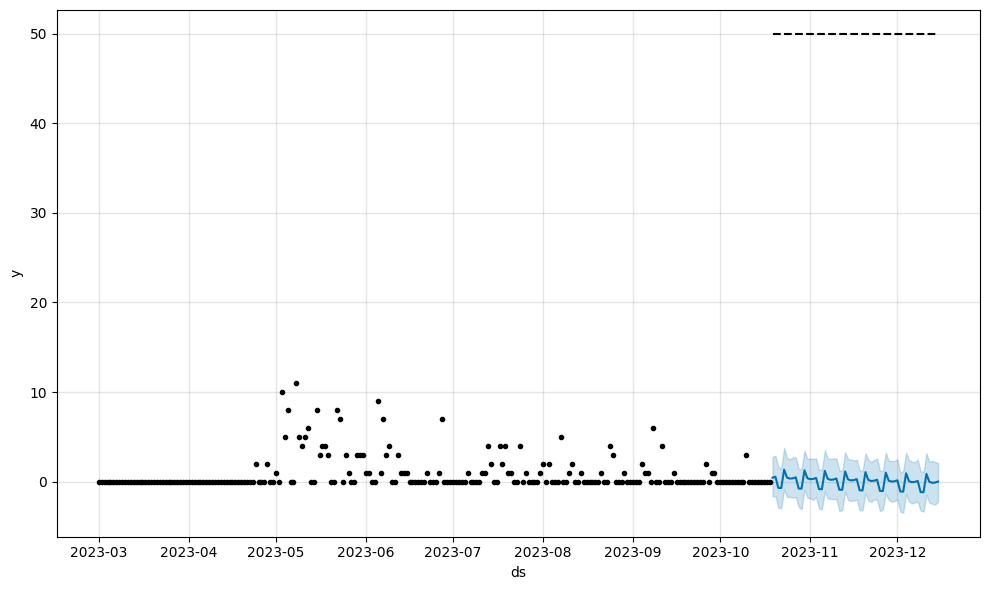

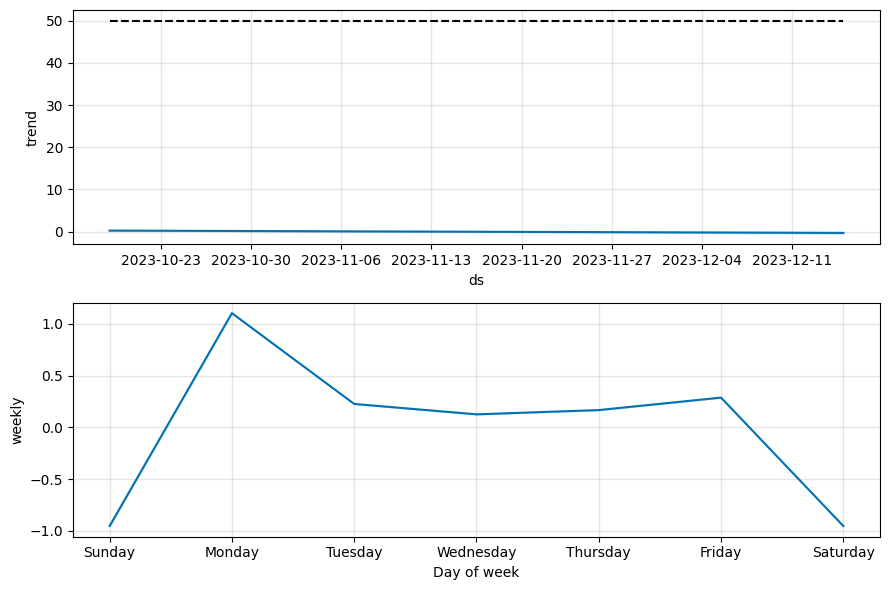

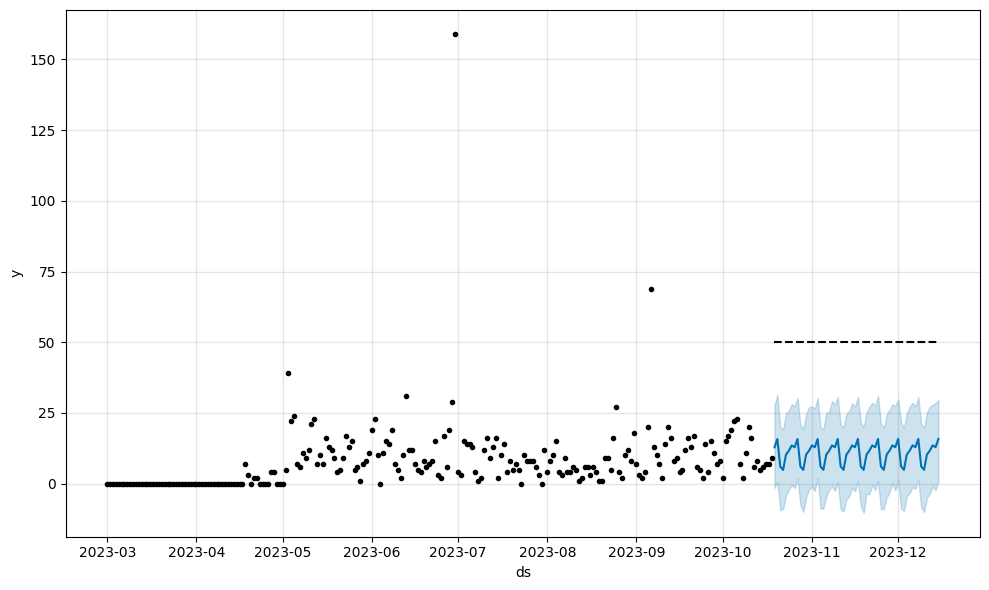

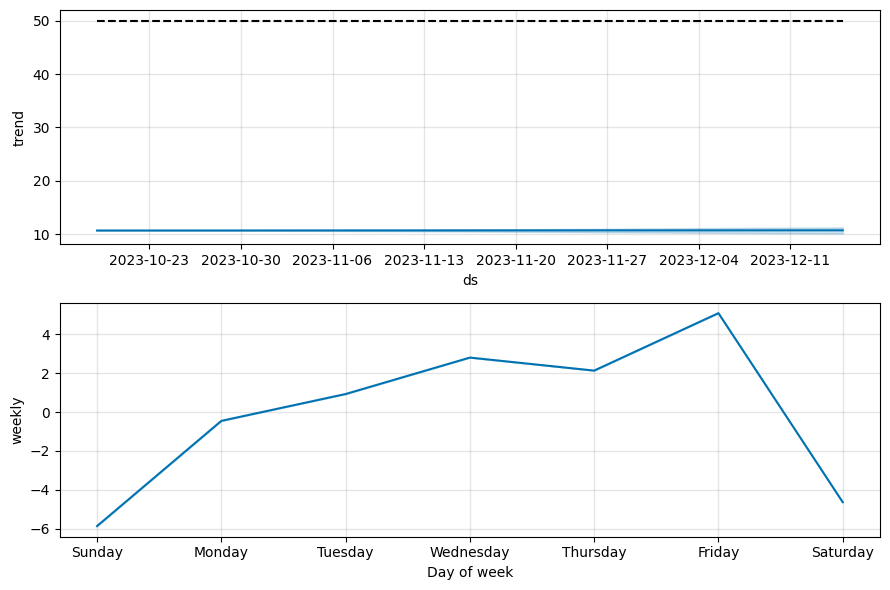

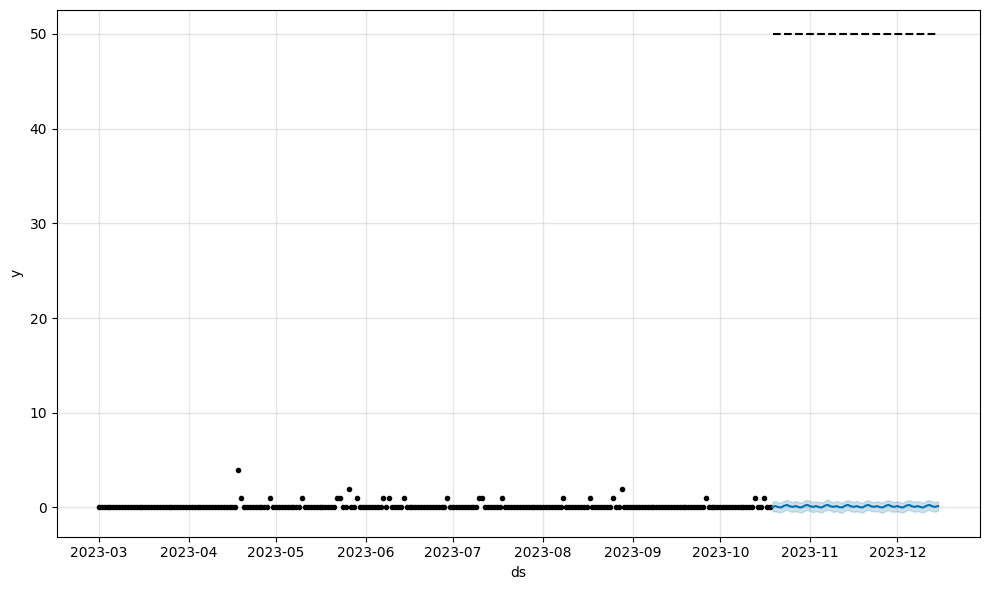

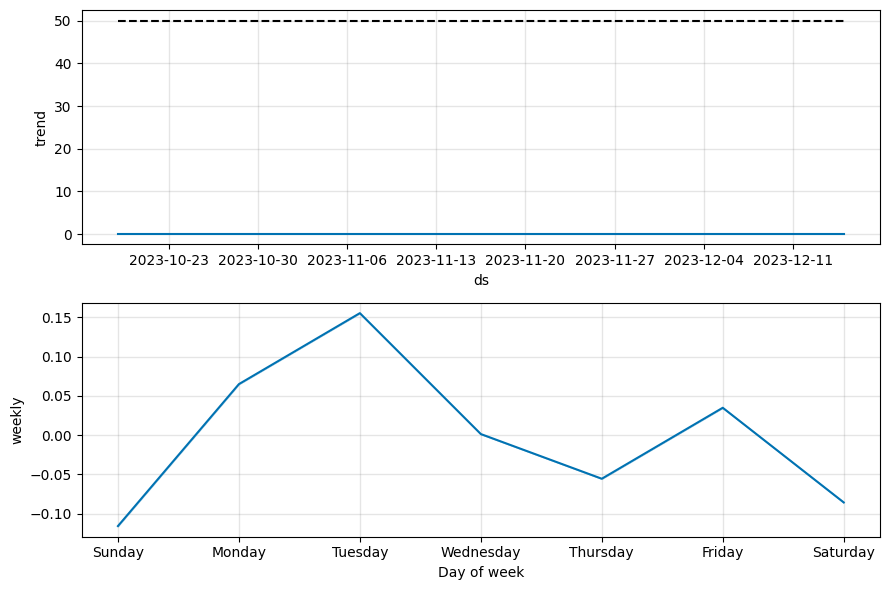

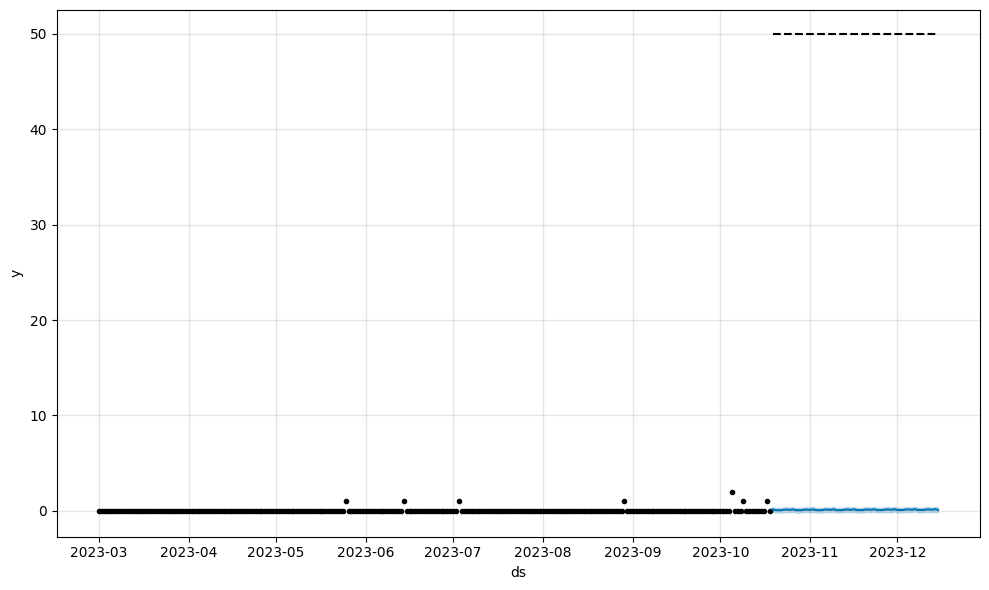

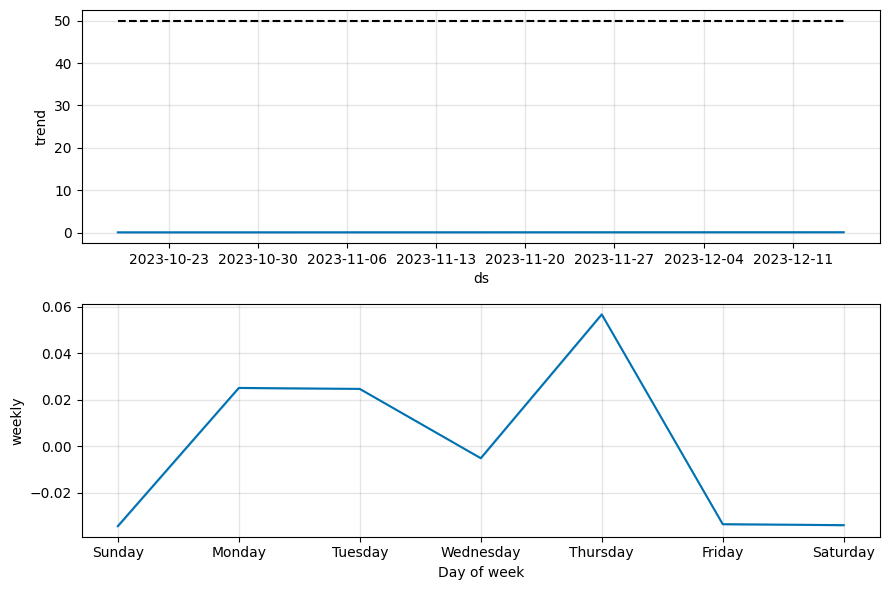

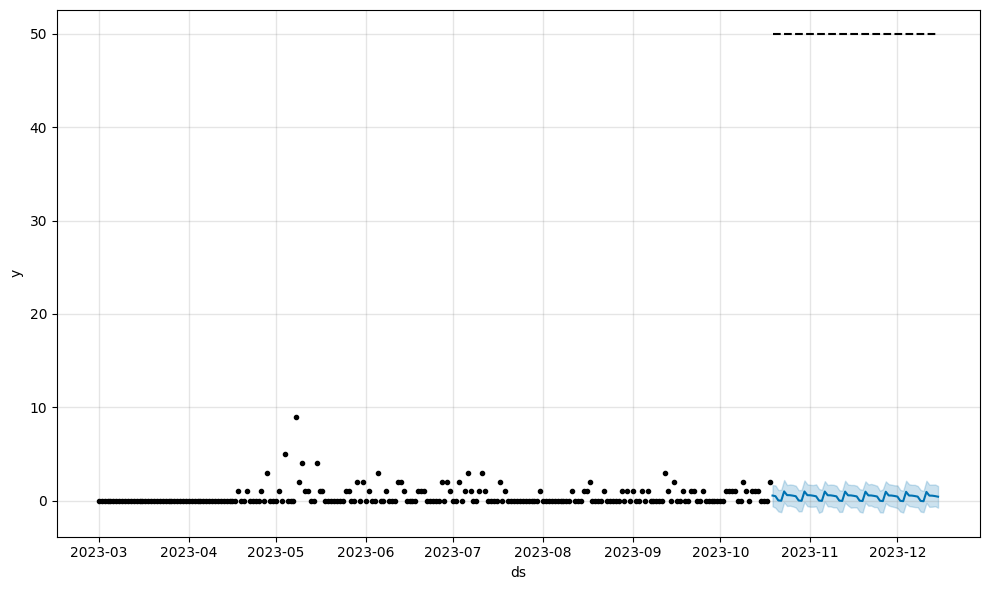

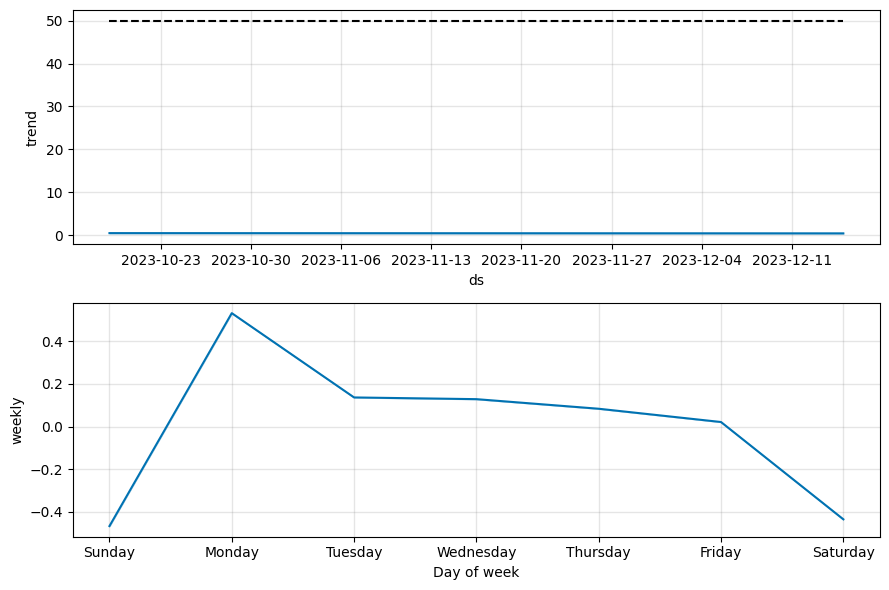

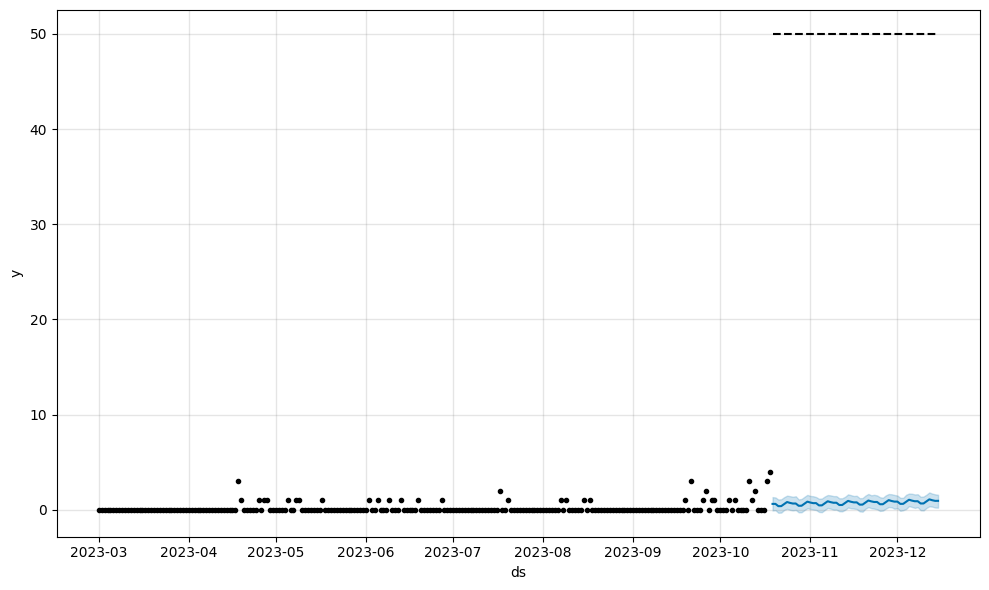

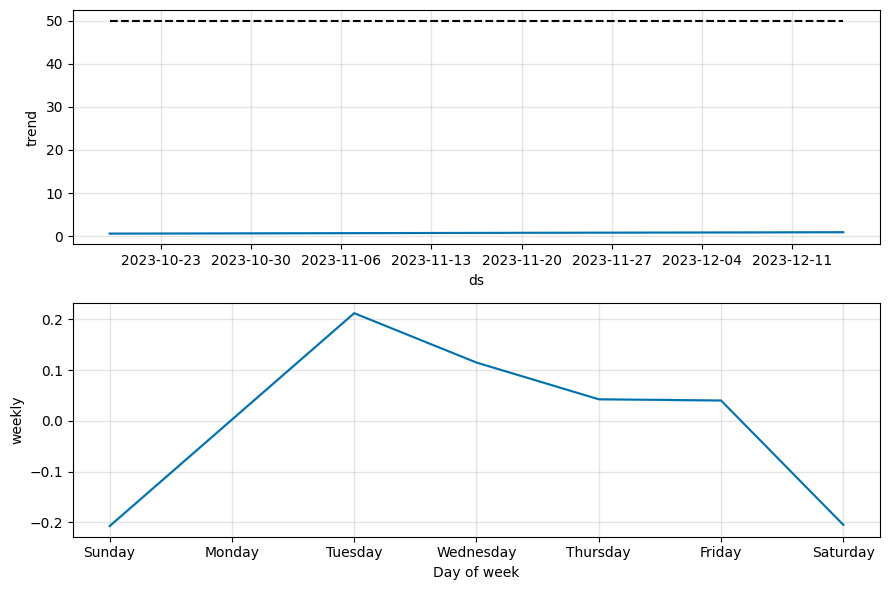

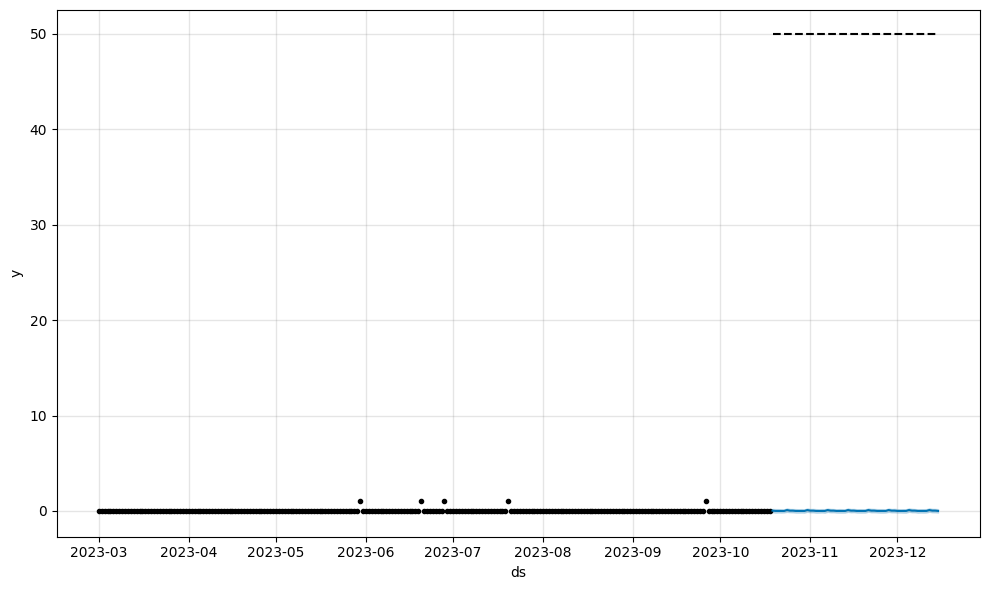

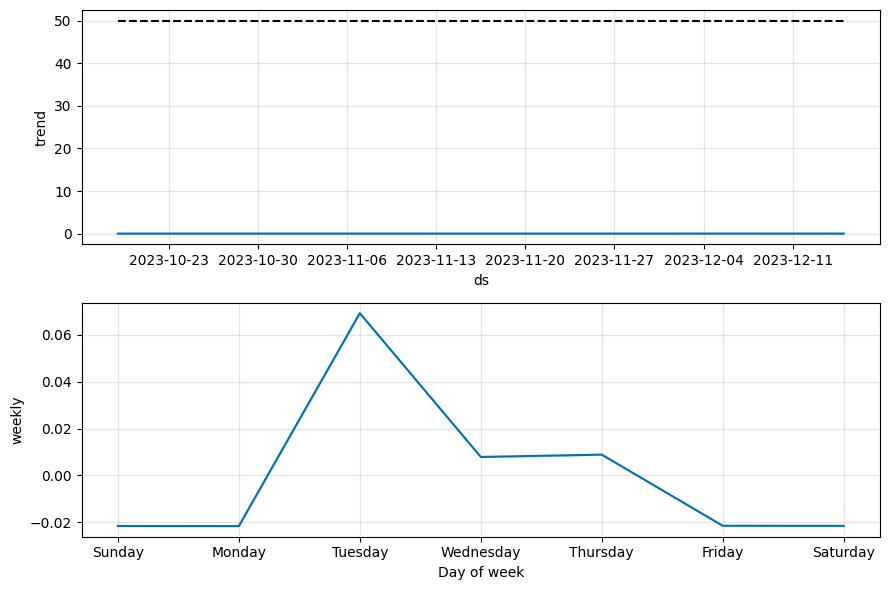

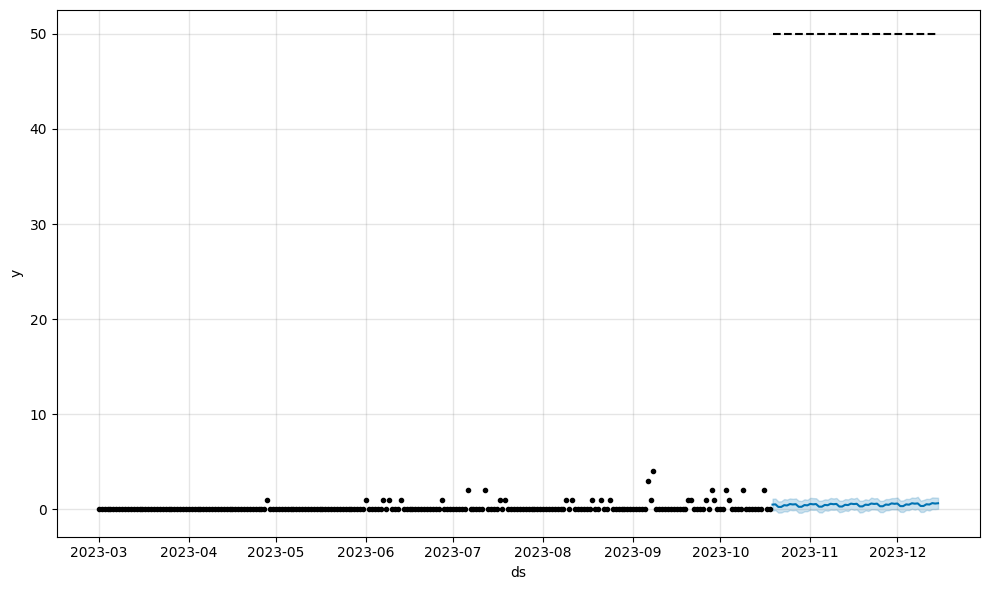

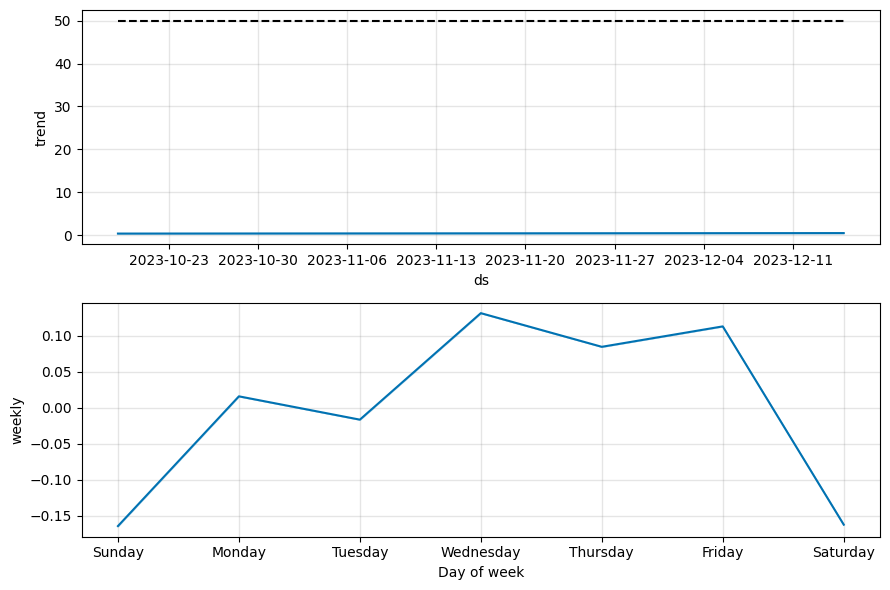

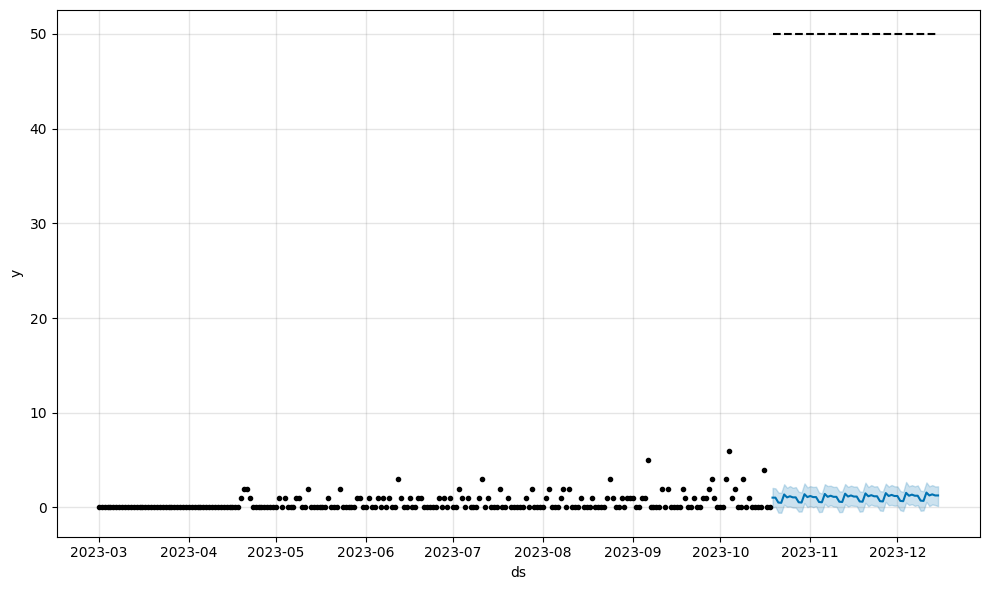

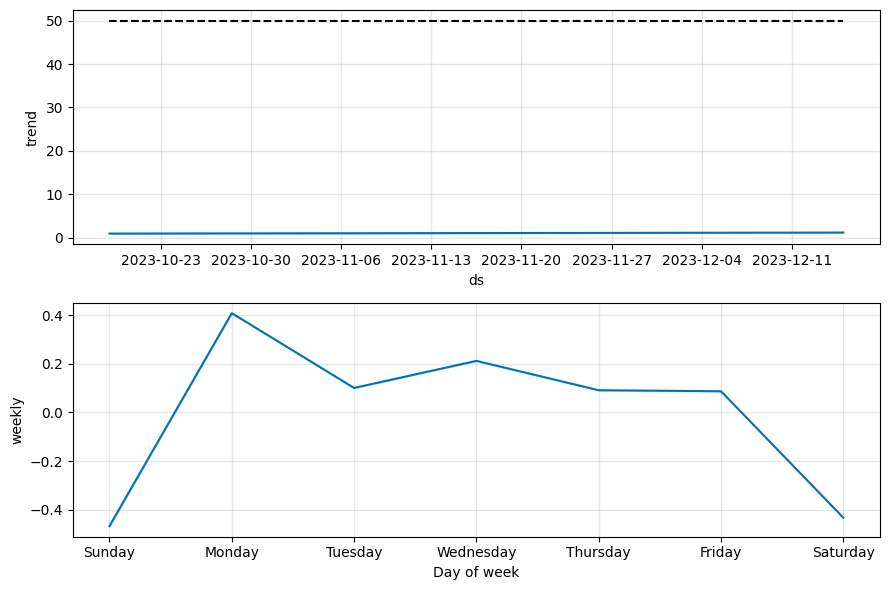

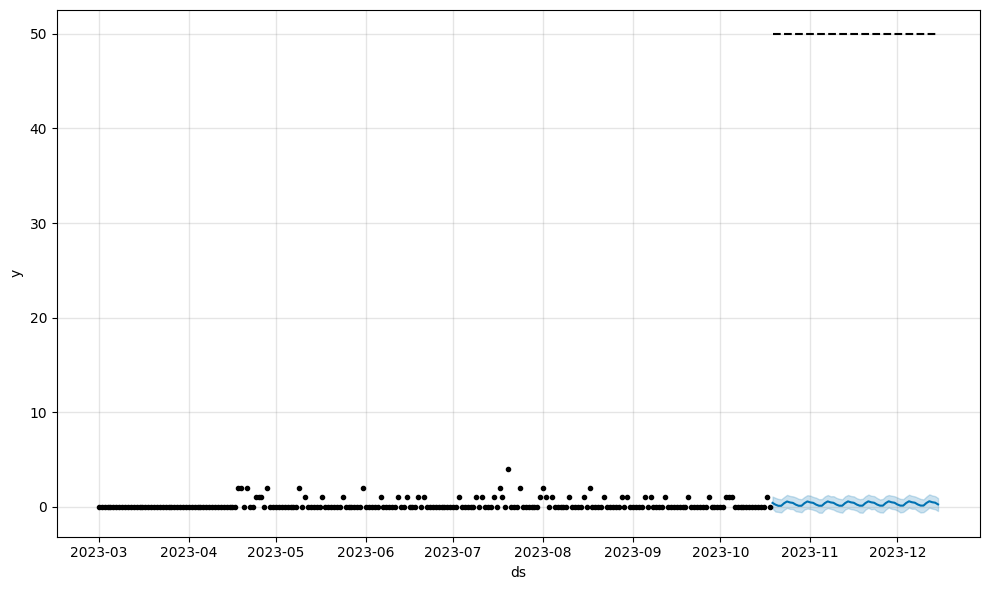

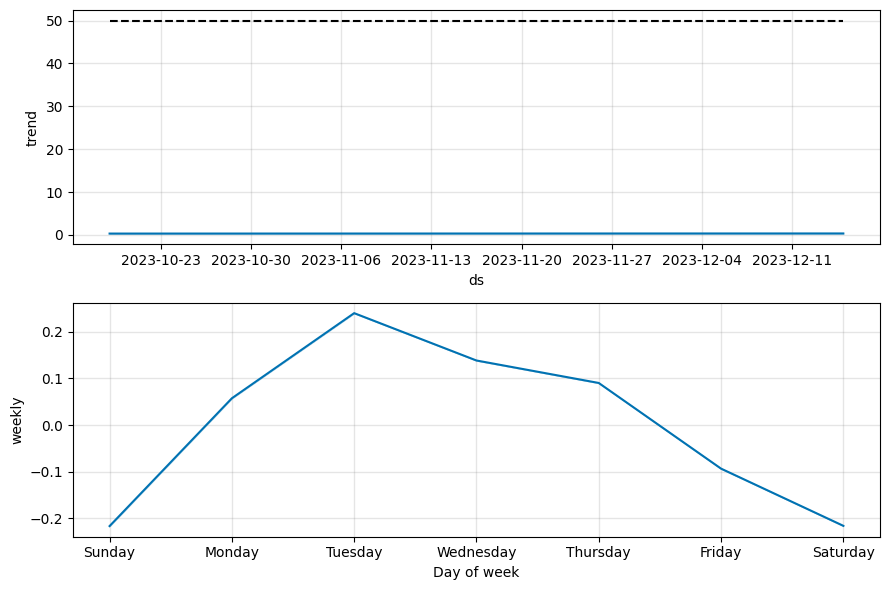

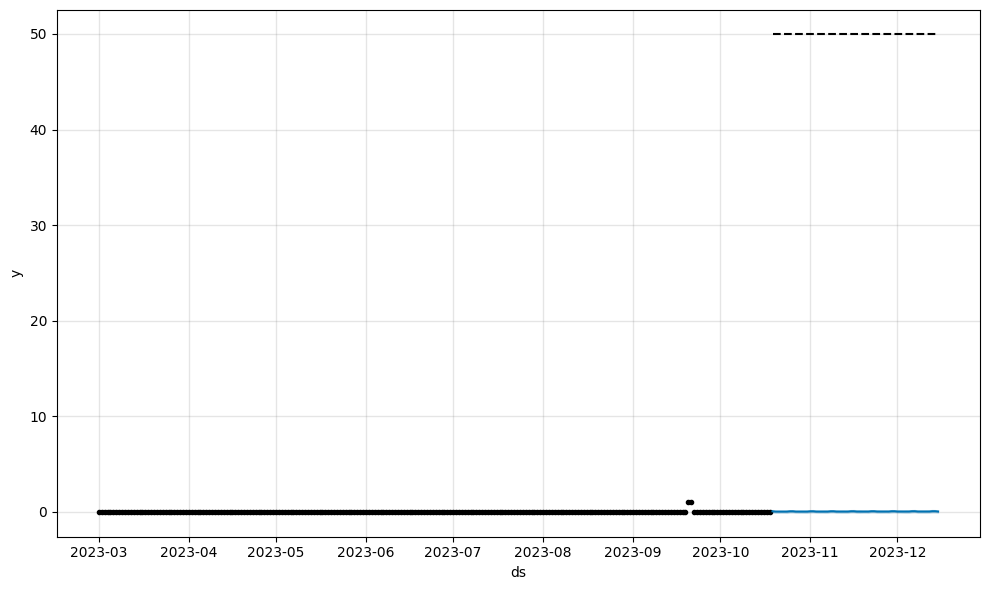

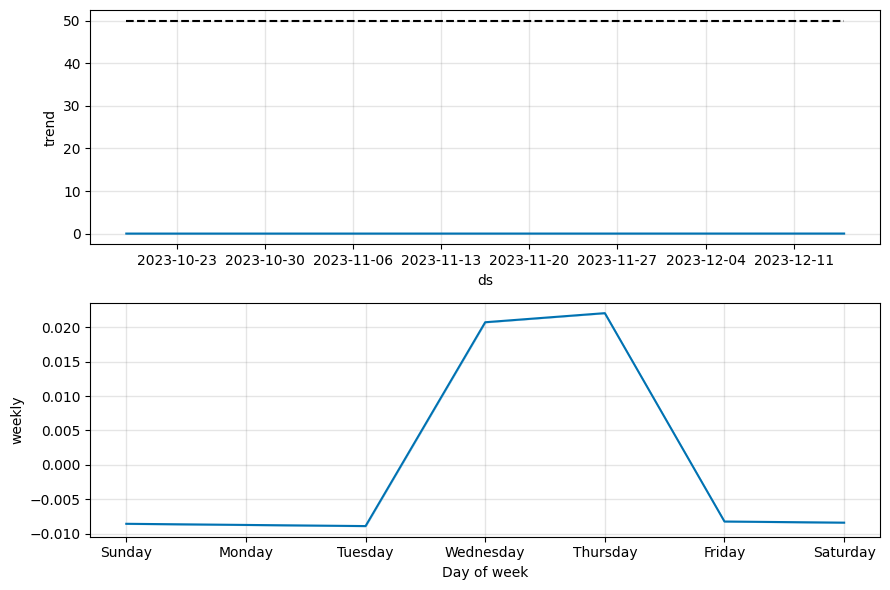

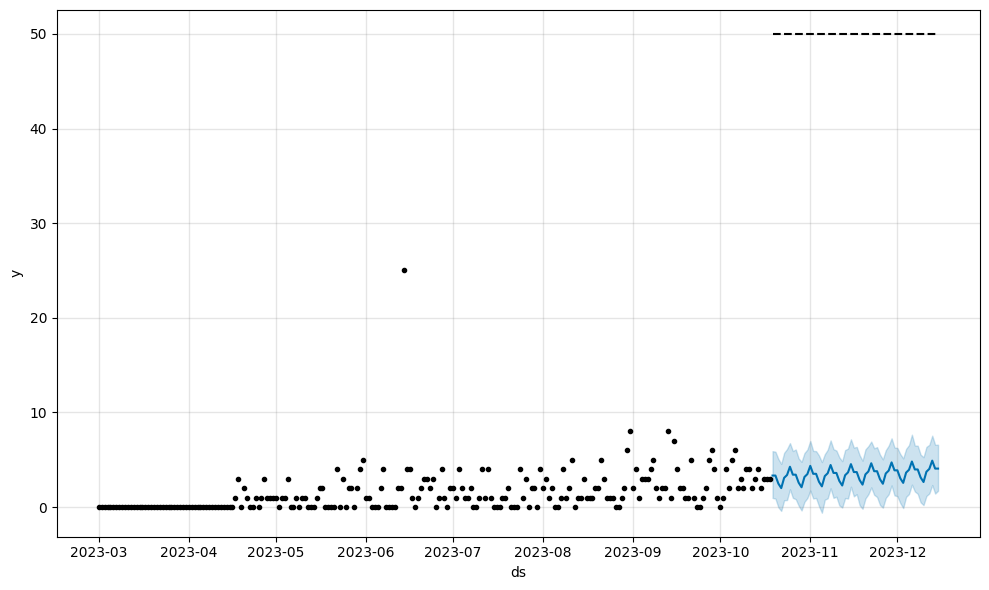

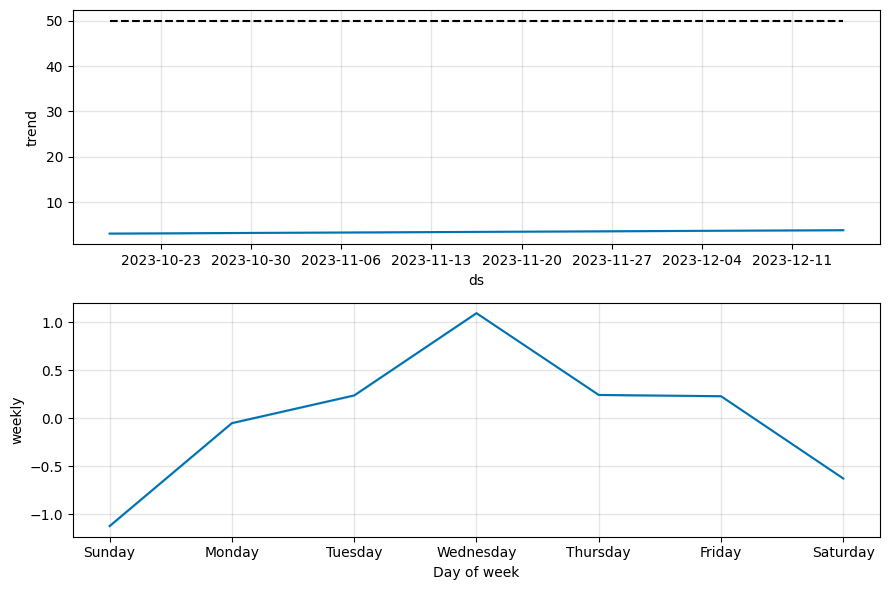

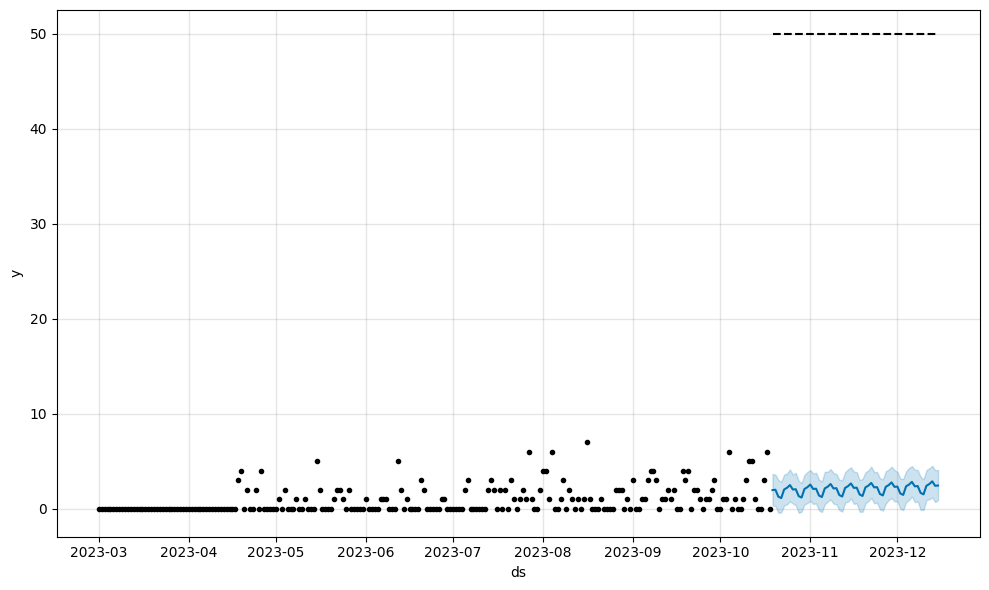

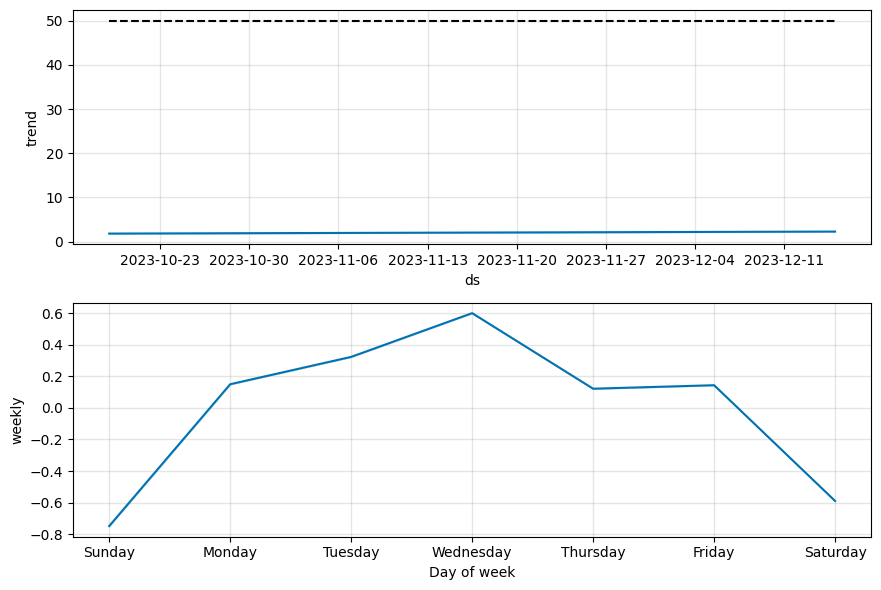

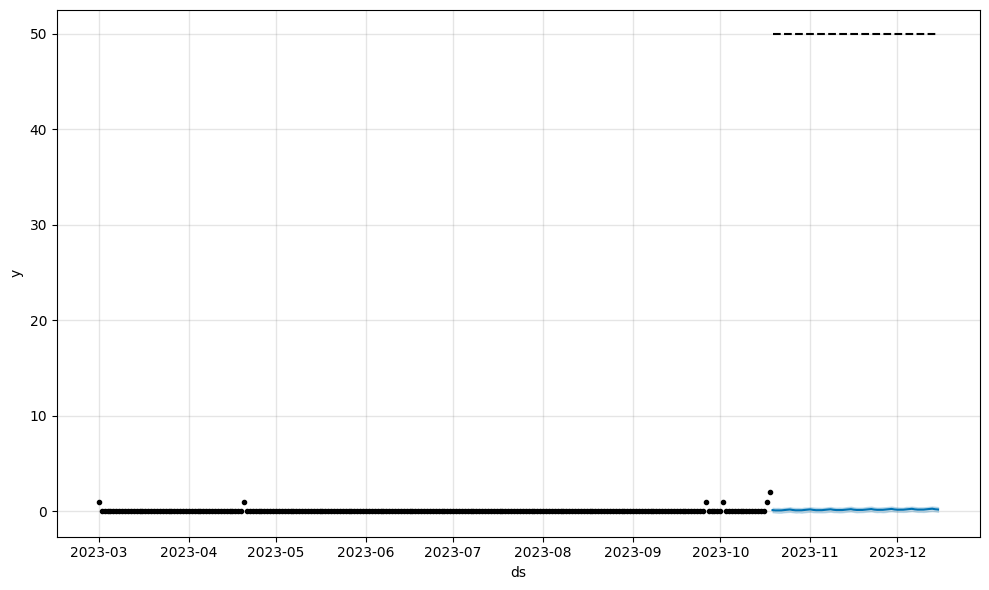

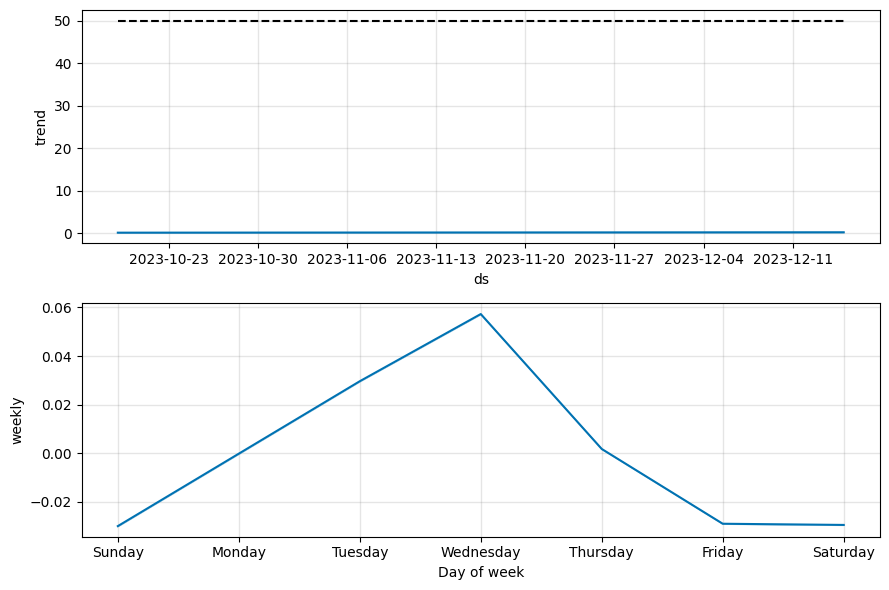

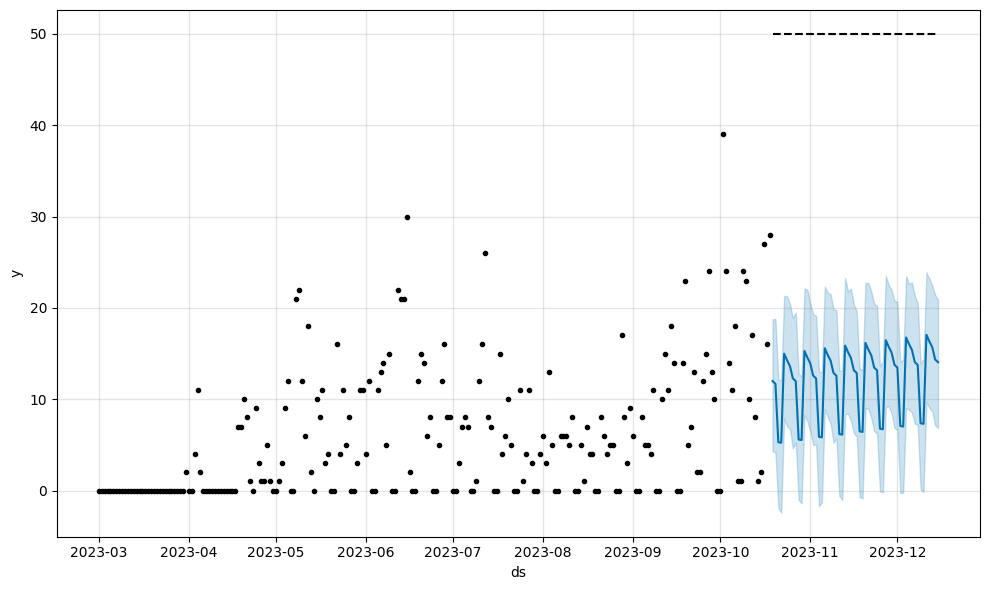

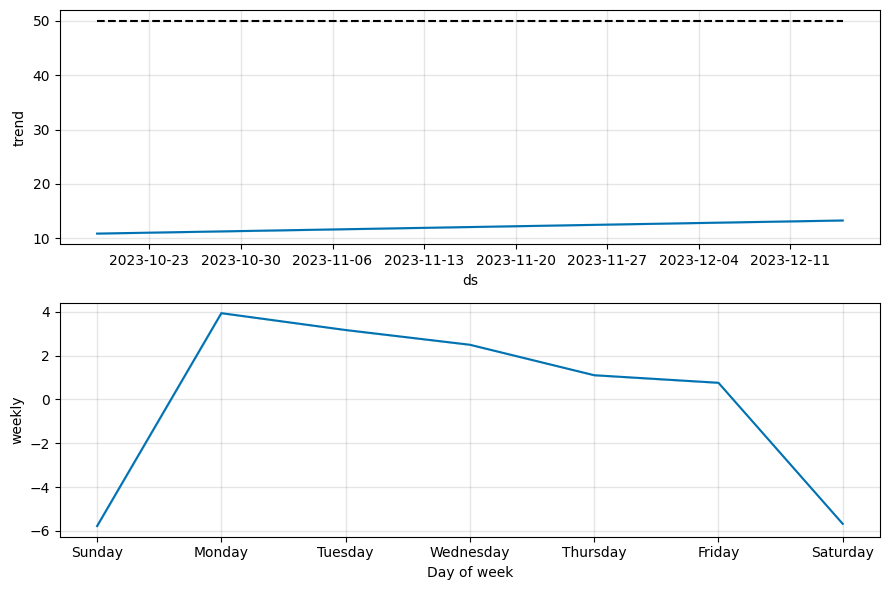

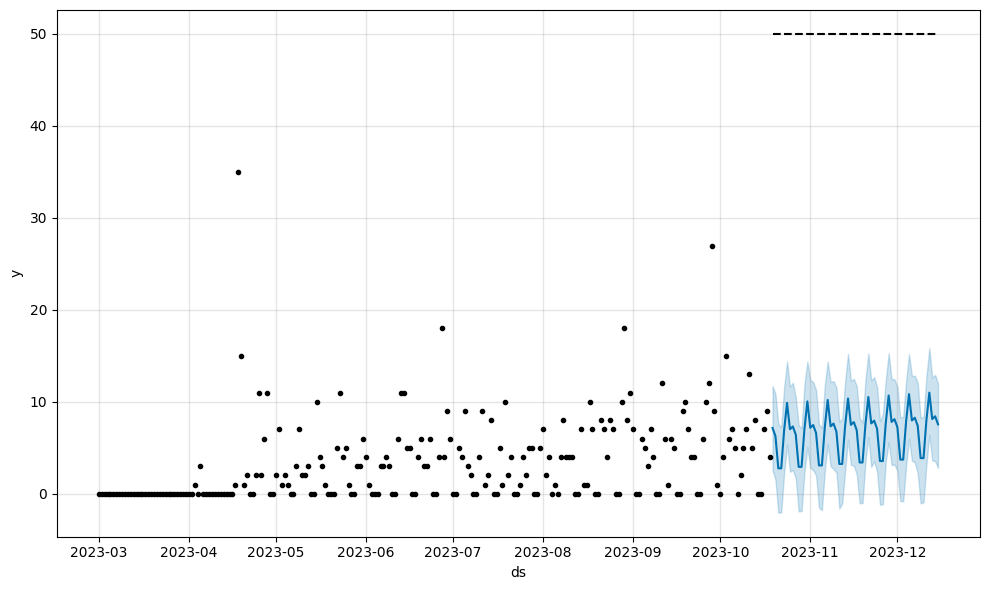

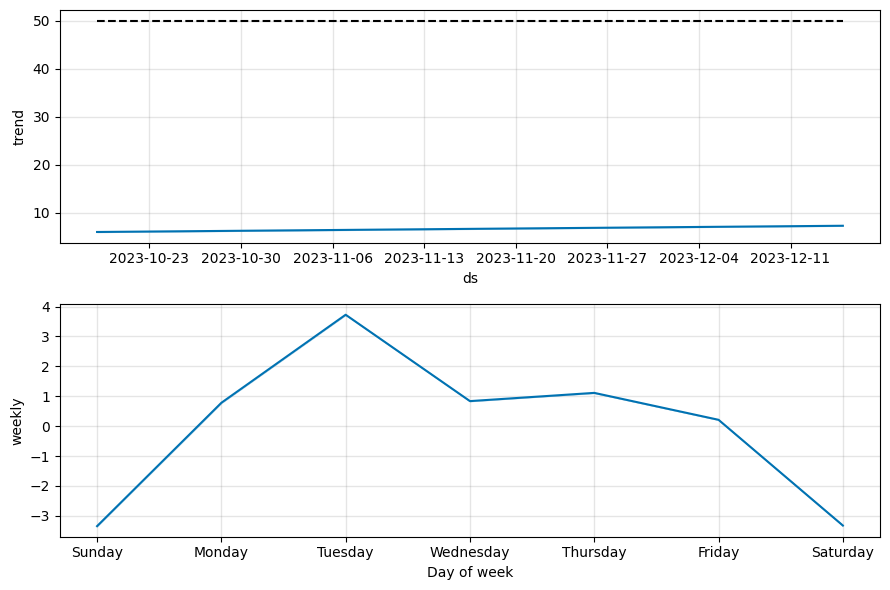

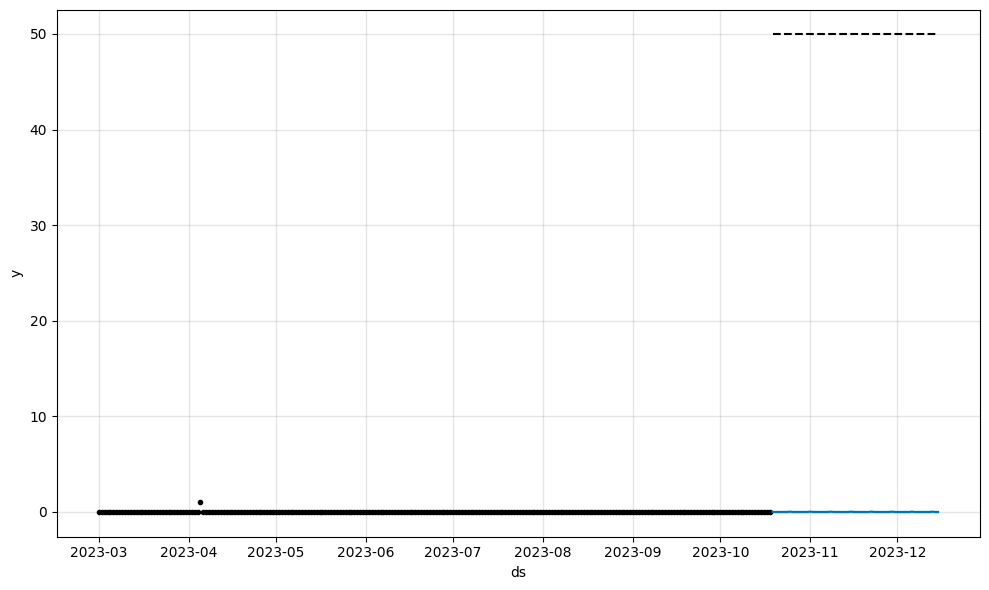

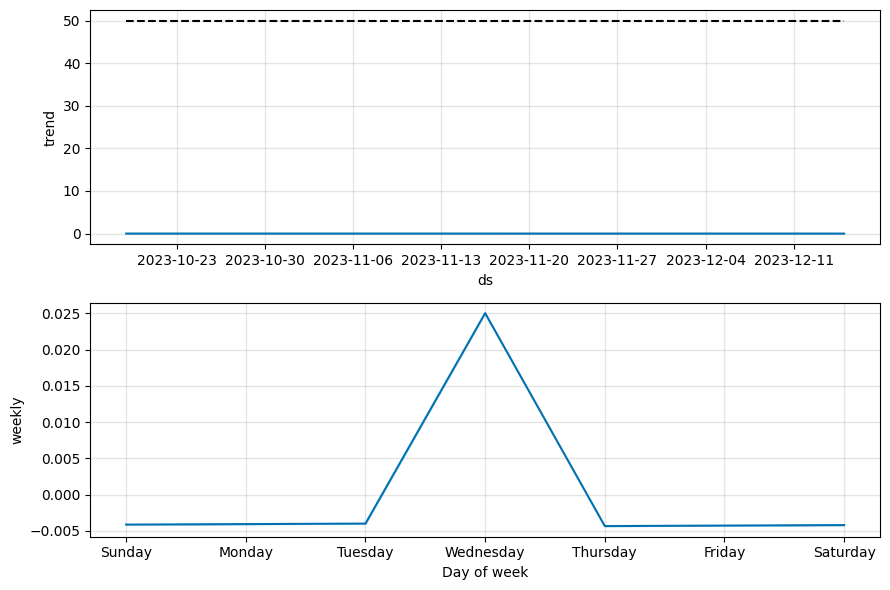

In [41]:
models_list = models_list_priority_category_wise  # List of trained models
forecast_list = forecast_list_priority_category_wise  # List of forecast results

# Iterate through the models and forecasts
for i in range(len(models_list)):
    print(i)

    # Plot the forecast for the current model
    models_list[i].plot(forecast_list[i])

    # Plot the components of the forecast for the current model
    models_list[i].plot_components(forecast_list[i])
